# Getting Data & Libraries

In [1]:
!kaggle datasets download blastchar/telco-customer-churn

Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
100%|█████████████████████████████████████████| 172k/172k [00:00<00:00, 278kB/s]
100%|█████████████████████████████████████████| 172k/172k [00:00<00:00, 278kB/s]


In [2]:
!unzip telco-customer-churn.zip

Archive:  telco-customer-churn.zip
  inflating: WA_Fn-UseC_-Telco-Customer-Churn.csv  


# Loading Libraries, Setting Stuff Up

In [1]:
import pandas as pd
import numpy as np

import sweetviz as sv

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense

import warnings
warnings.filterwarnings('ignore')

In [2]:
#loading data
path = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(path)

# Initial Look At the Data to Make Obvious Changes -drop Customer IDs, set datatypes, etc.

                                             |      | [  0%]   00:00 -> (? left)


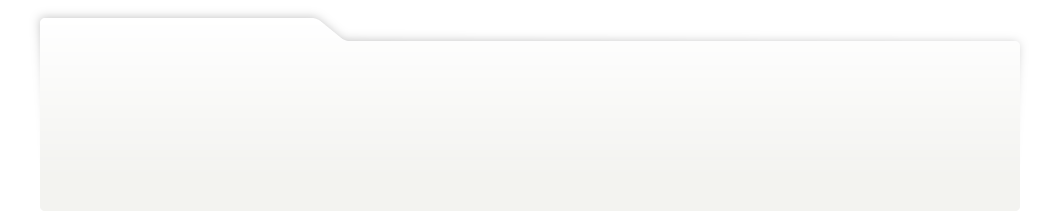
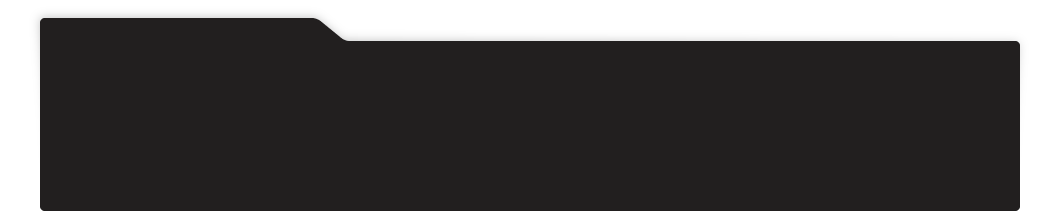
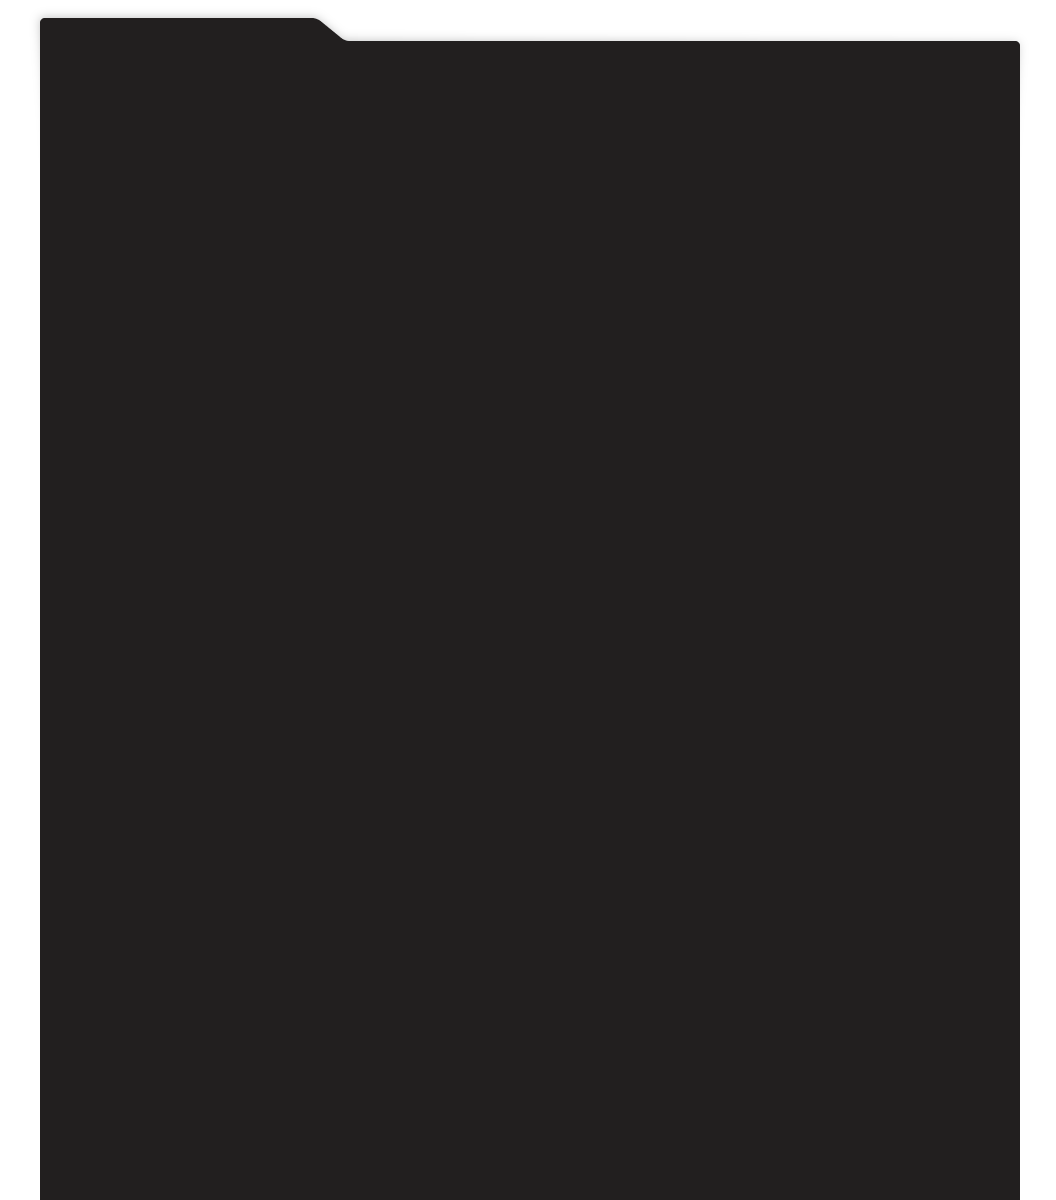
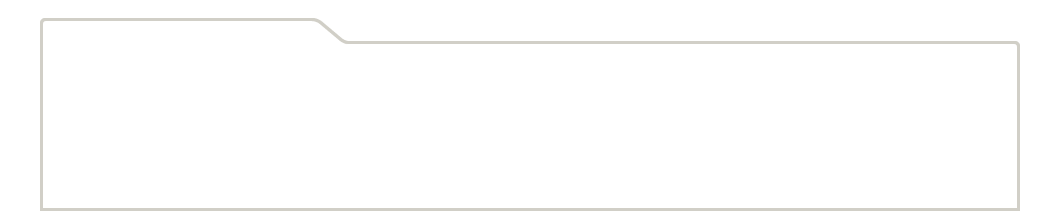
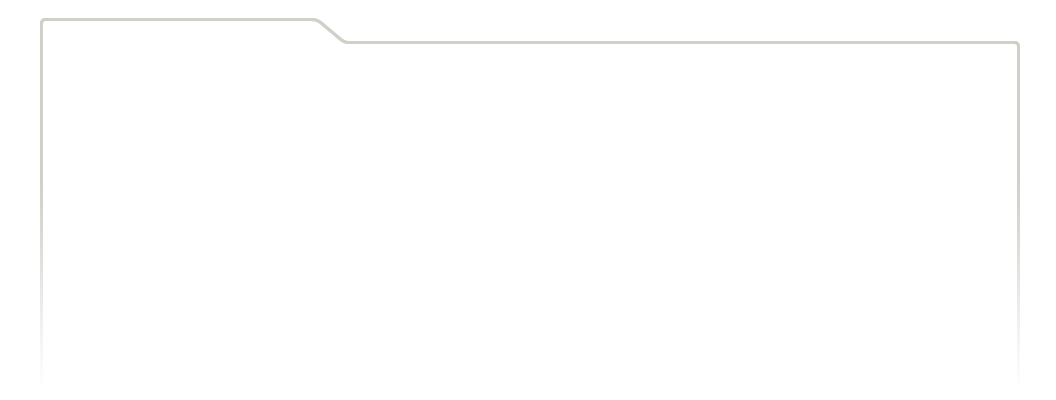
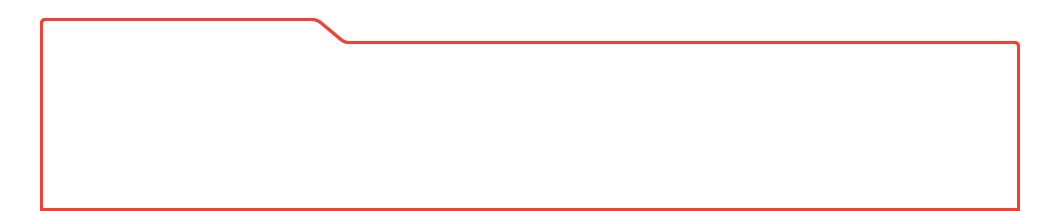
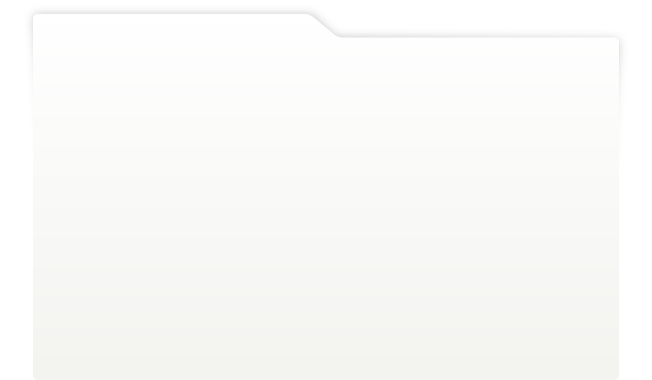
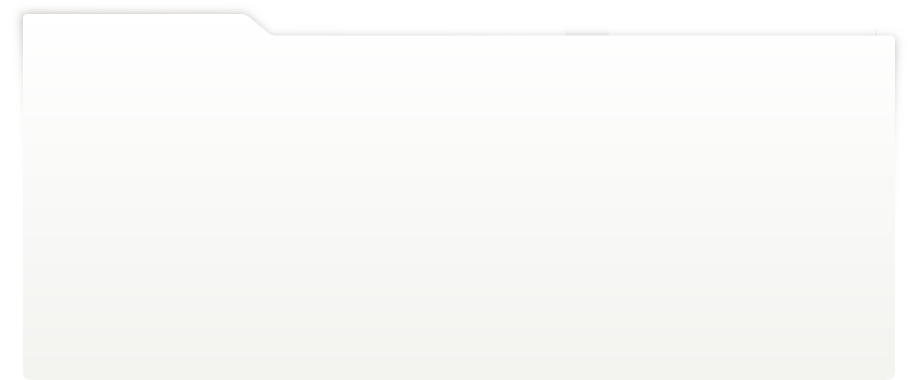
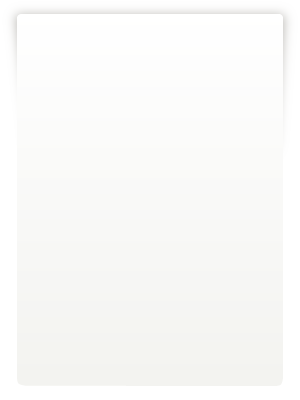
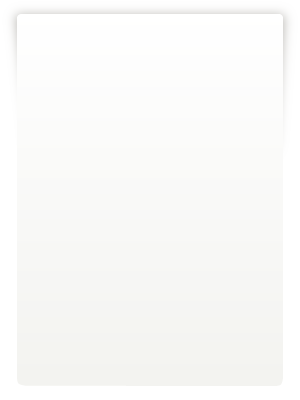
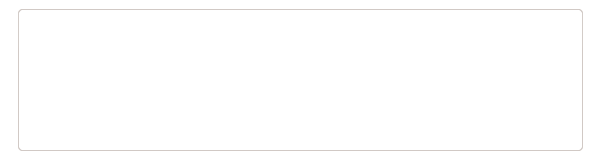
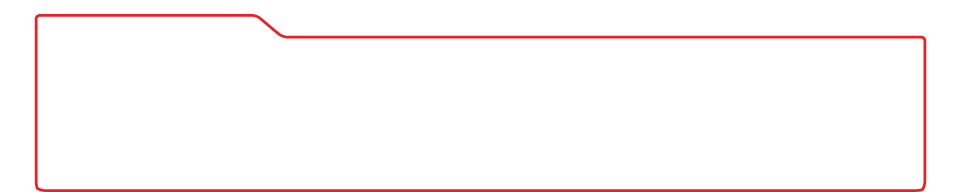
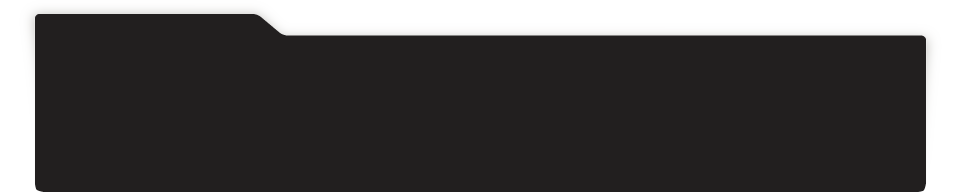
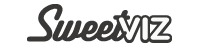
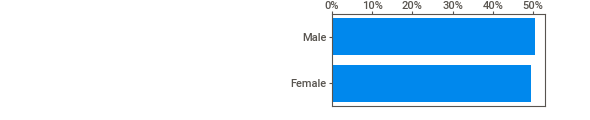
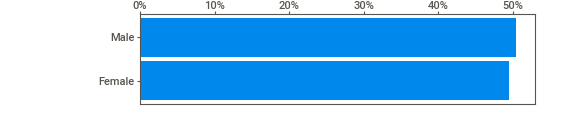
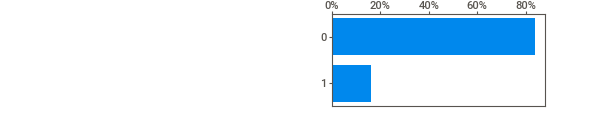
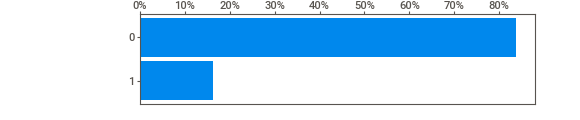
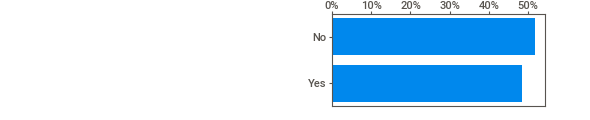
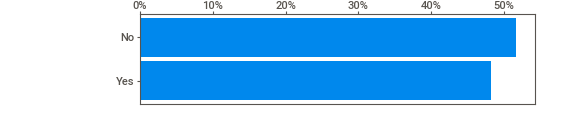
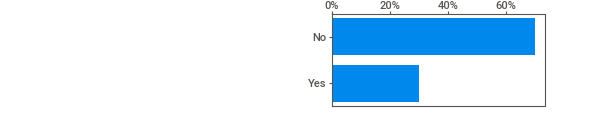
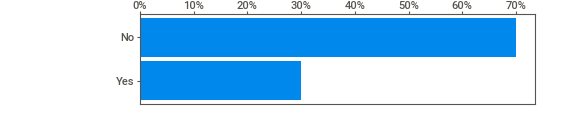
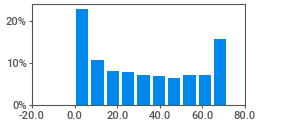
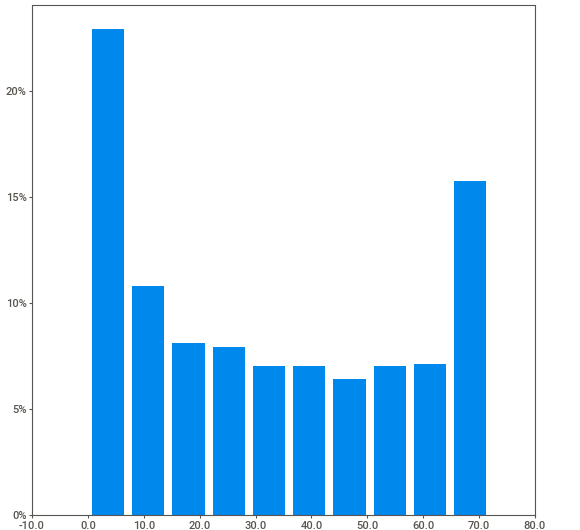
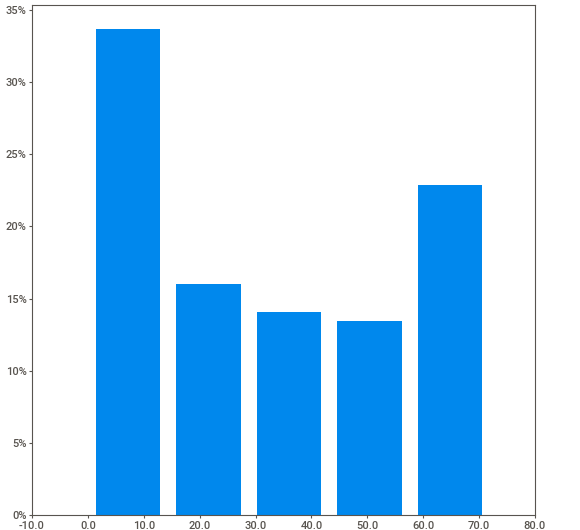
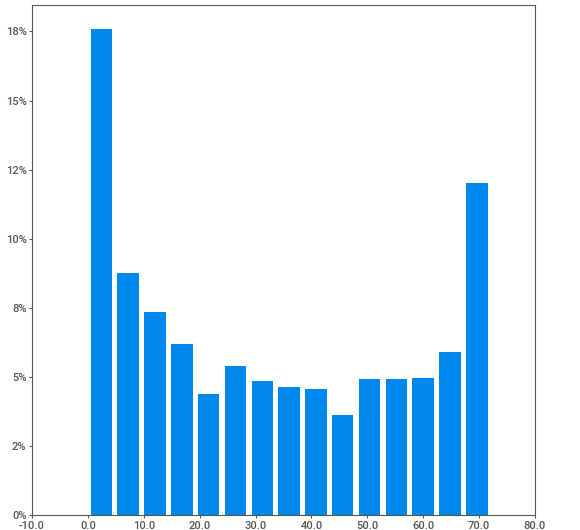
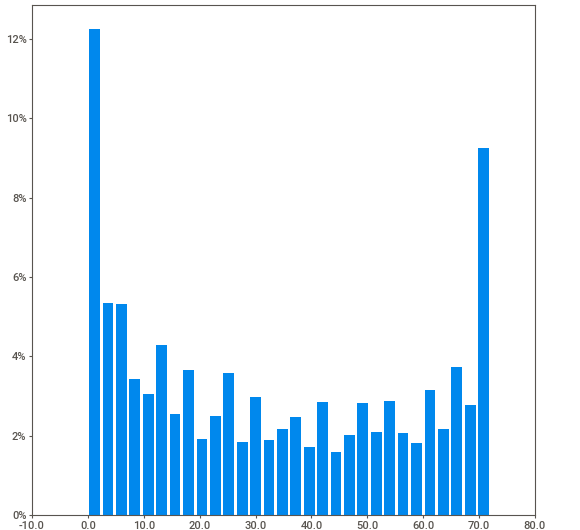
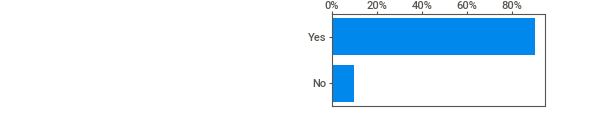
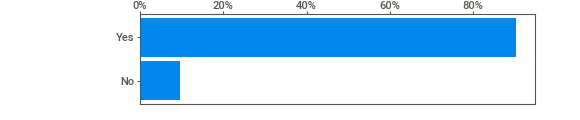
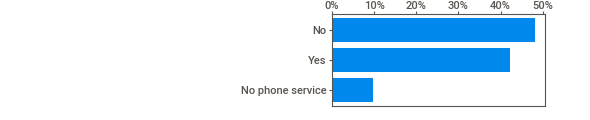
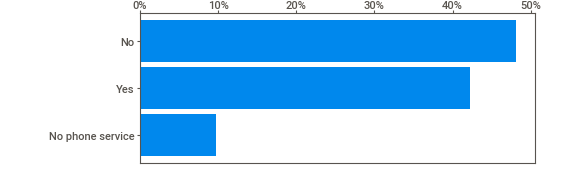
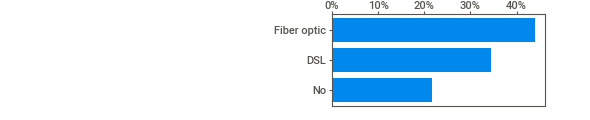
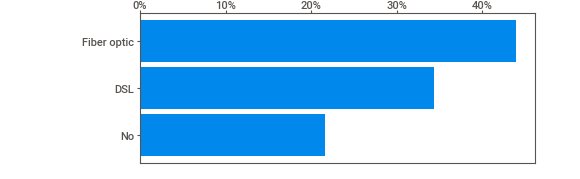
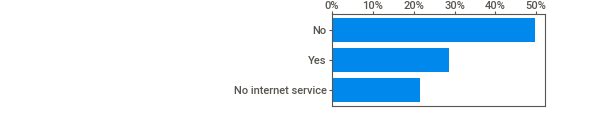
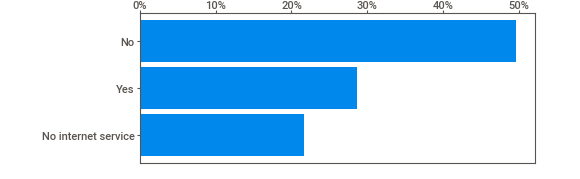
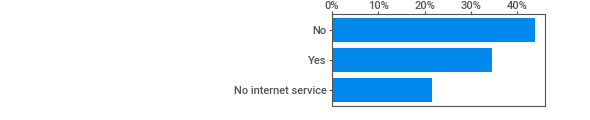
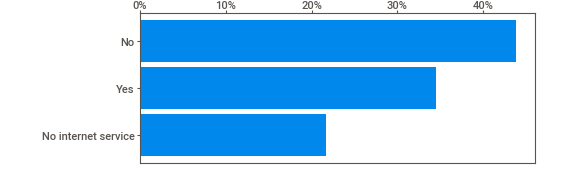
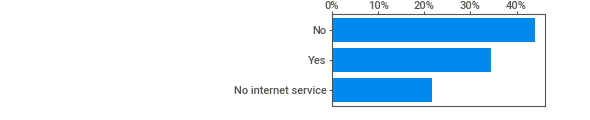
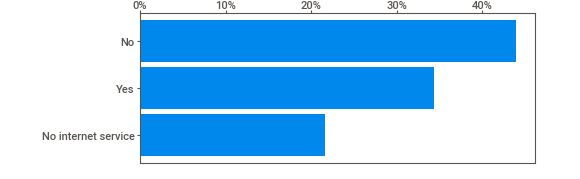
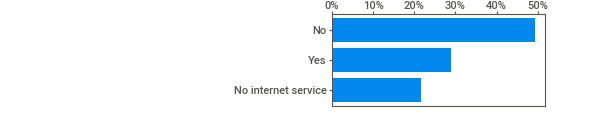
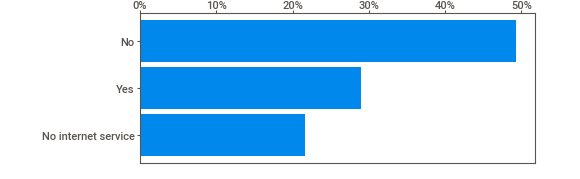
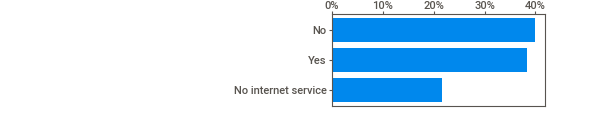
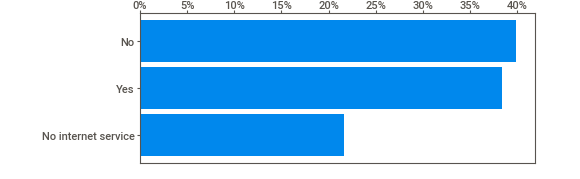
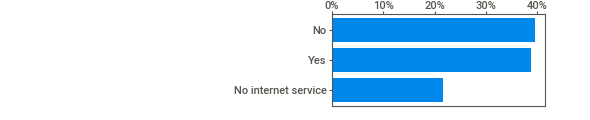
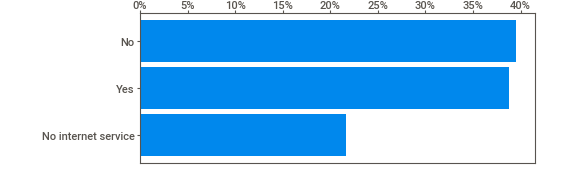
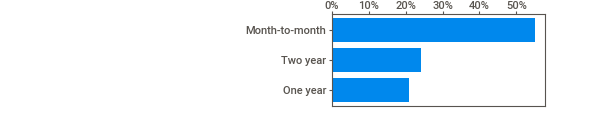
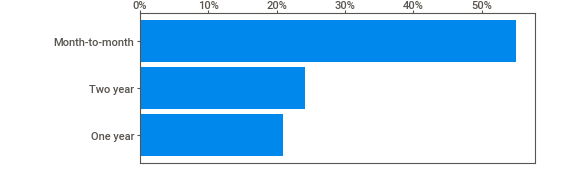
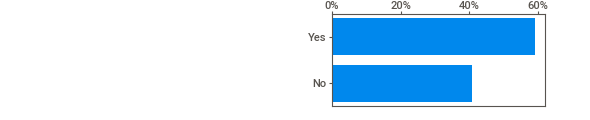
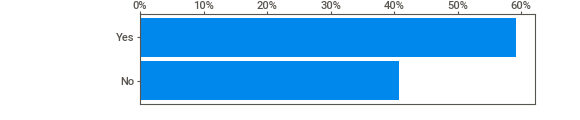
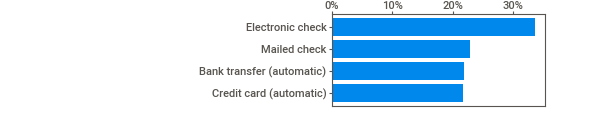
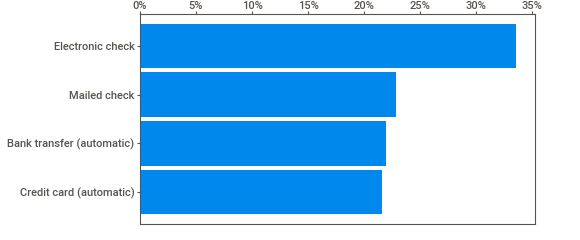
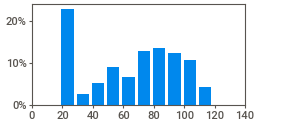
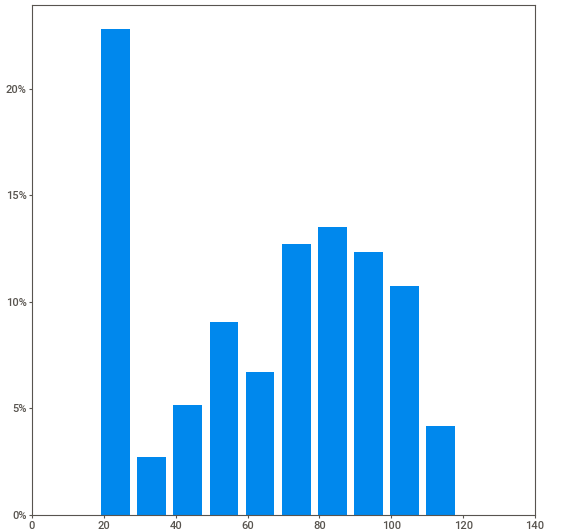
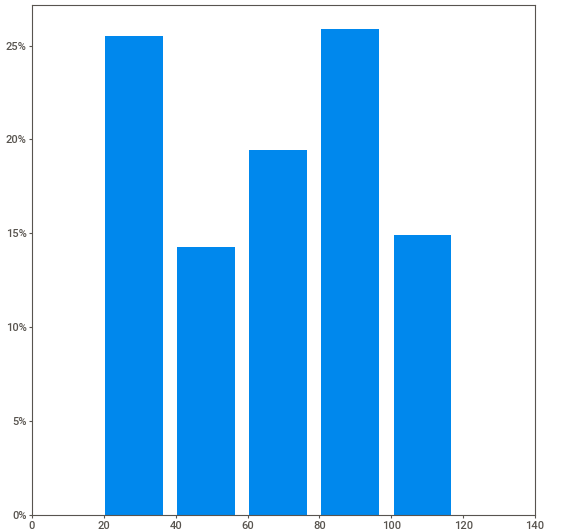
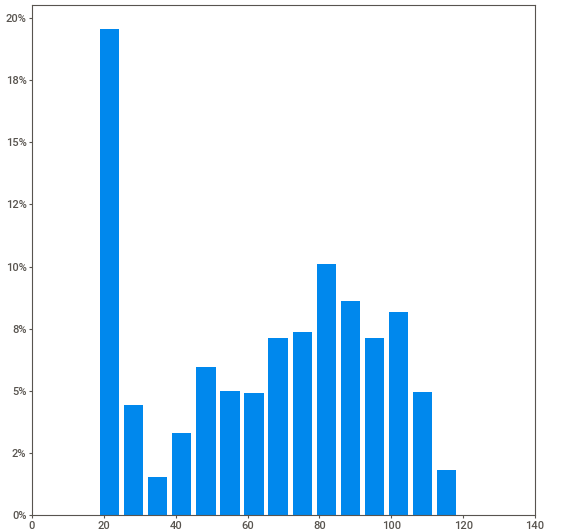
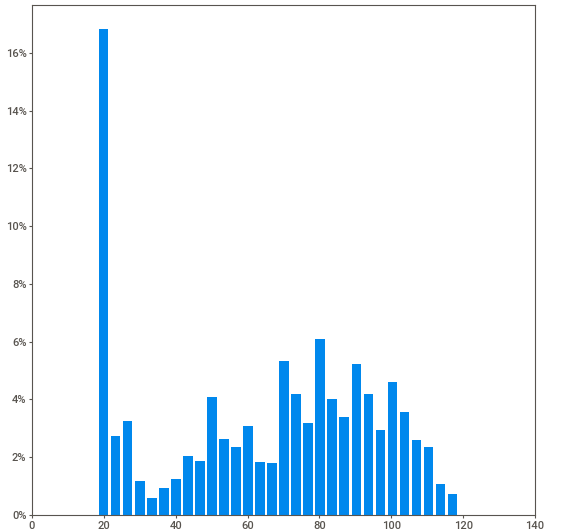
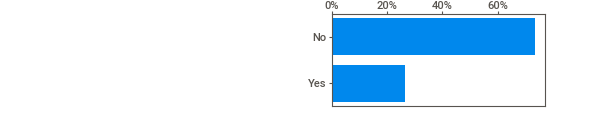
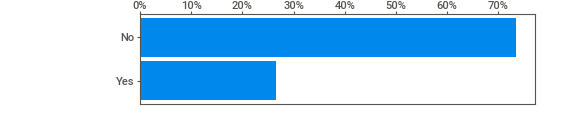
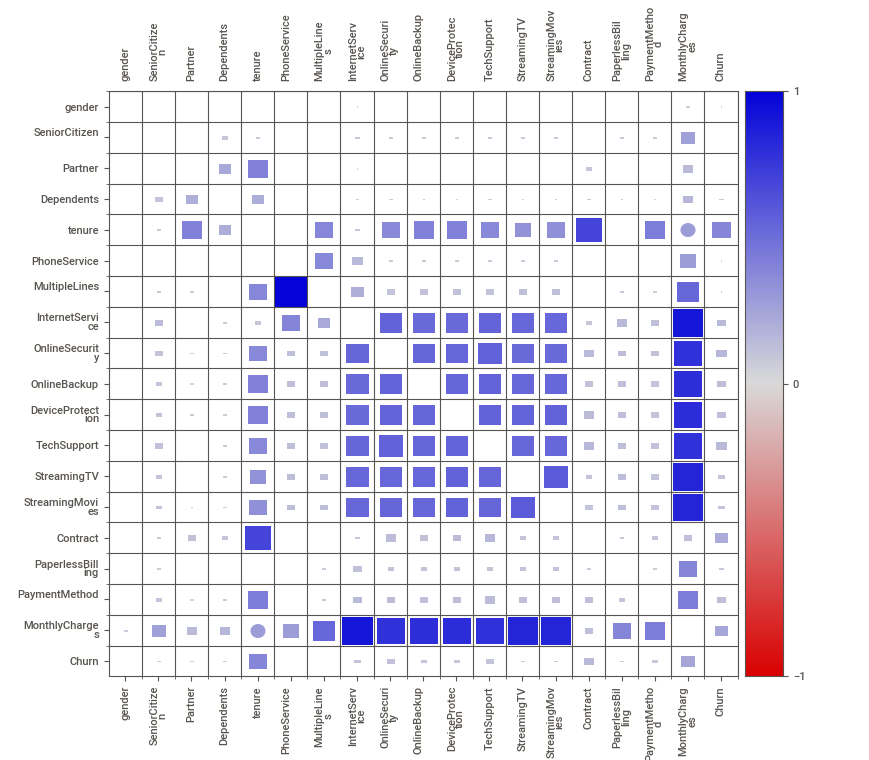
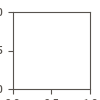

In [3]:
# create initial exploration reporting and show
report = sv.analyze(df)
report.show_notebook()

In [4]:
# Visualize missing values as a matrix
msno.matrix(df);

NameError: name 'msno' is not defined

> Using this matrix we can very quickly find the pattern of missingness in the dataset.
* From the above visualisation we can observe that it has no peculiar pattern that stands out. In fact there is no missing data.

***

In [5]:
df = df.drop(['customerID'], axis=1)

In [6]:
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')

In [7]:
df.drop(labels = df[df['tenure']==0].index, axis=0, inplace=True)

In [8]:
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

# Diving into Data and Deriving Insights

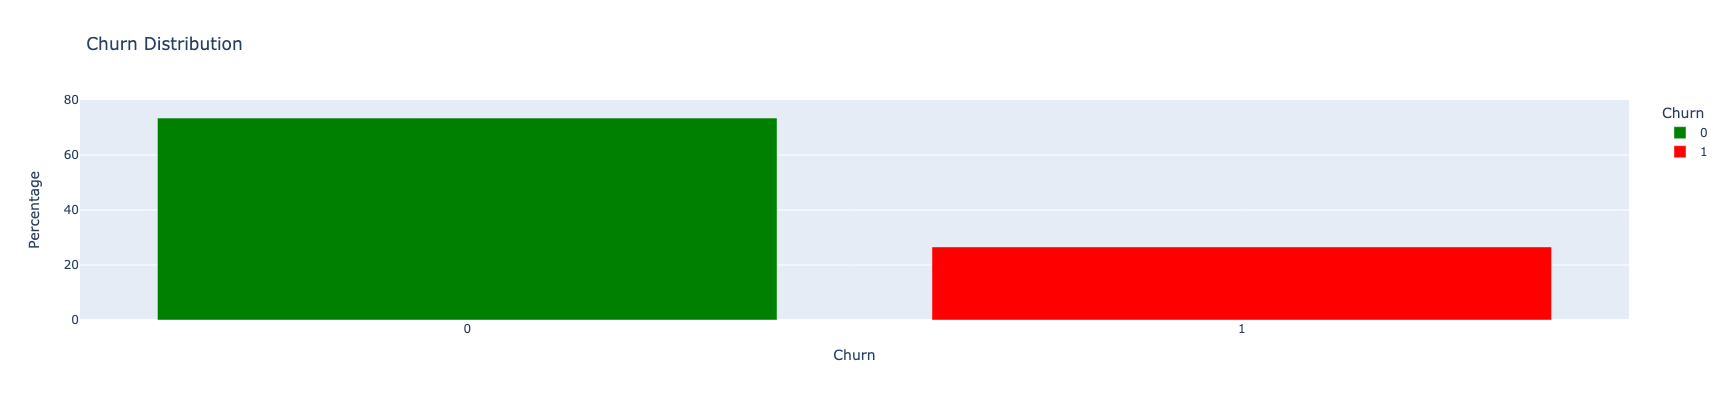

In [9]:
# Calculate percentage for Churn distribution
churn_counts = df['Churn'].value_counts(normalize=True).reset_index()
churn_counts.columns = ['Churn', 'Percentage']  # Rename columns for clarity
churn_counts['Percentage'] *= 100  # Convert to percentage
churn_counts['Churn'] = churn_counts['Churn'].astype(str)  # Convert to string

# Create bar chart for Churn distribution
fig_churn = px.bar(
    churn_counts, 
    x='Churn', 
    y='Percentage', 
    title='Churn Distribution',
    color='Churn',  # Specify the color column
    color_discrete_map={'1': 'red', '0': 'green'}  # Map colors for '1' and '0'
)

# Update layout for Churn chart
fig_churn.update_layout(width=600, height=400)  # Adjust width and height
fig_churn.update_yaxes(range=[0, 80], dtick=20)  

# Show the figure
fig_churn.show()

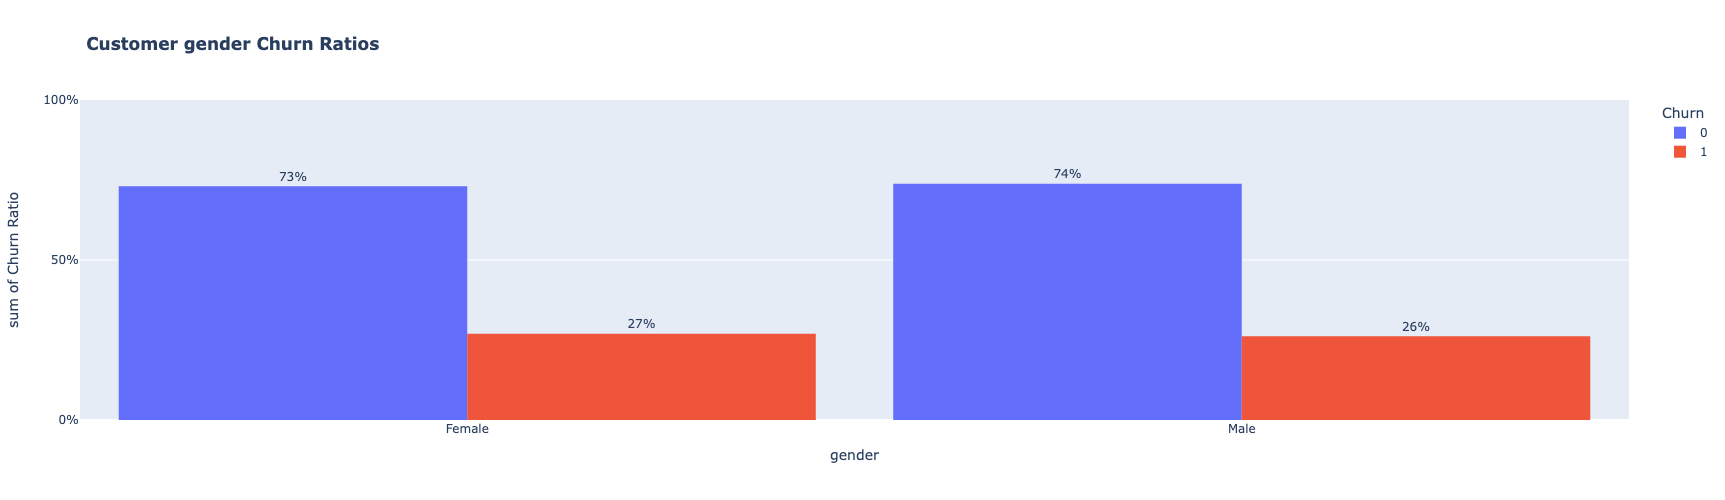

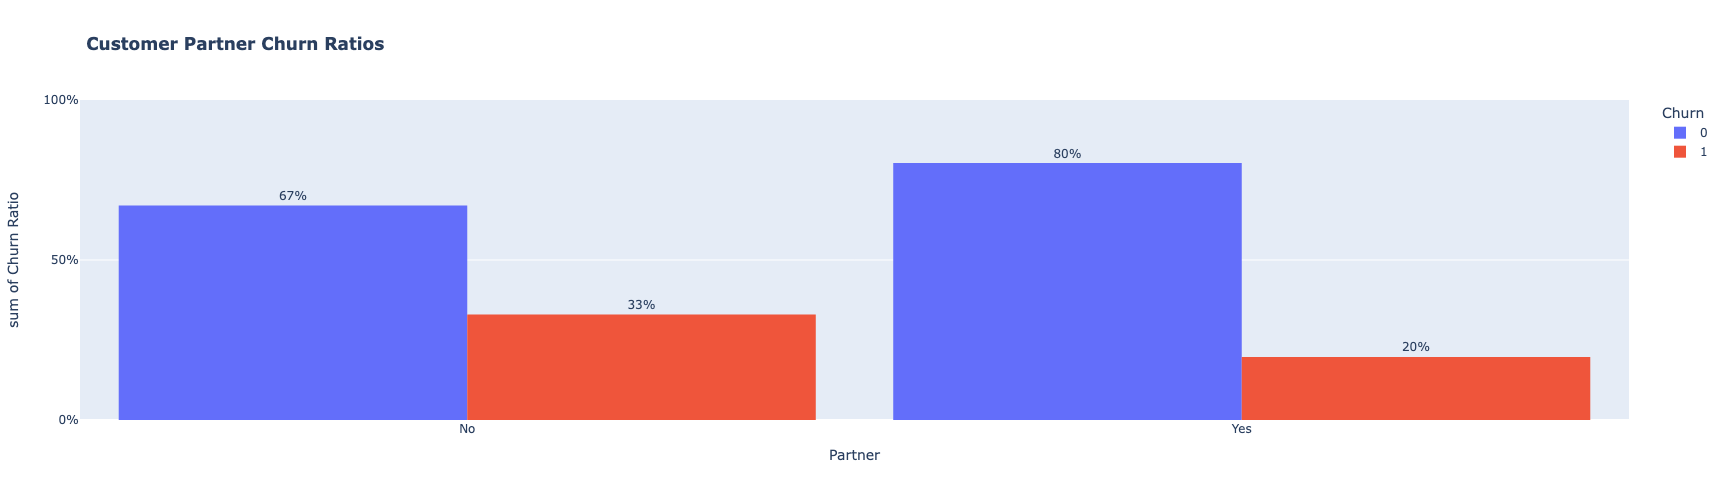

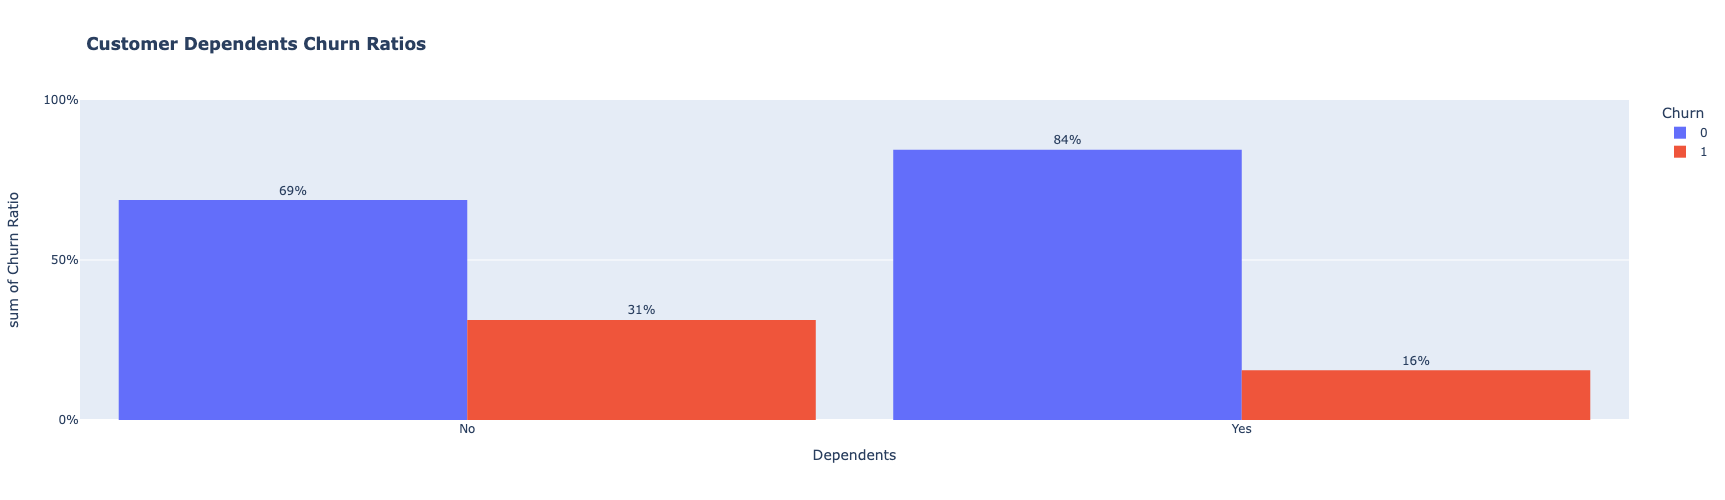

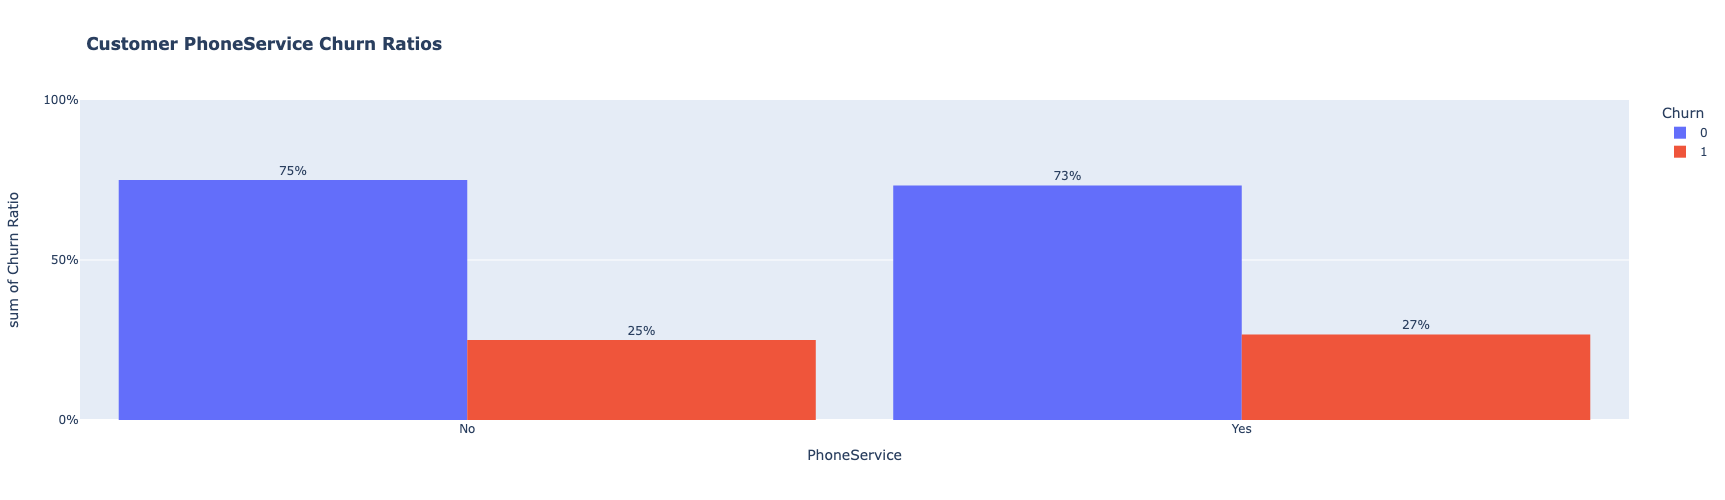

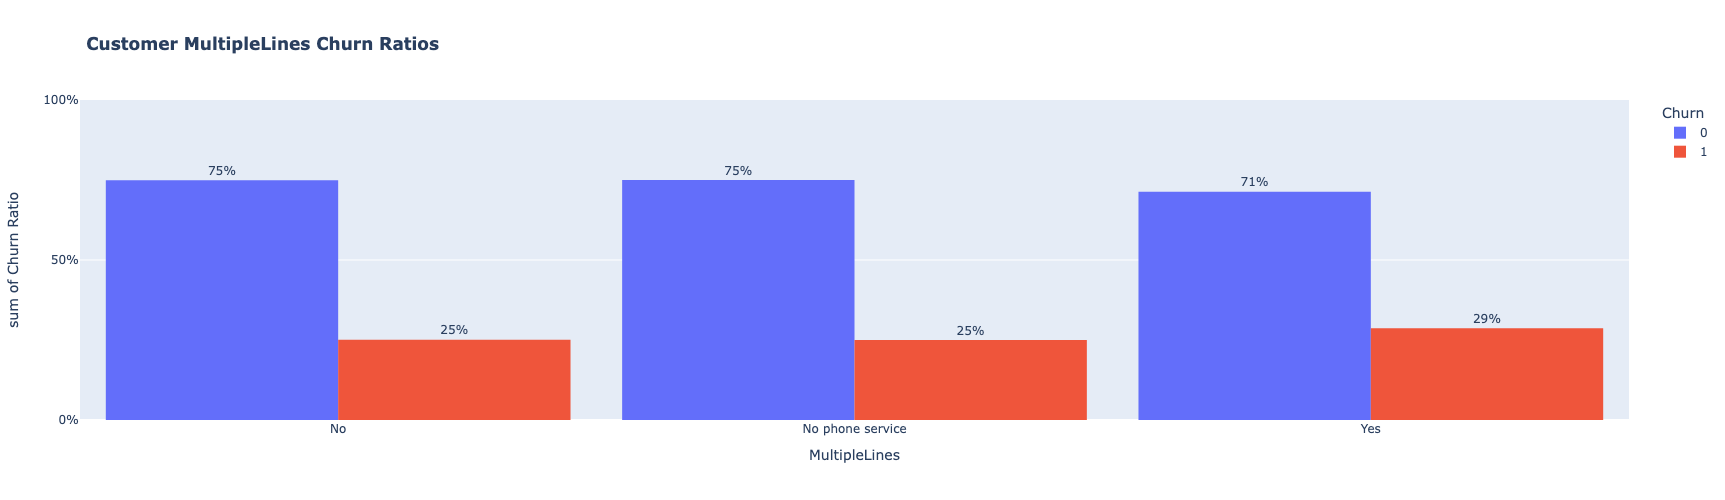

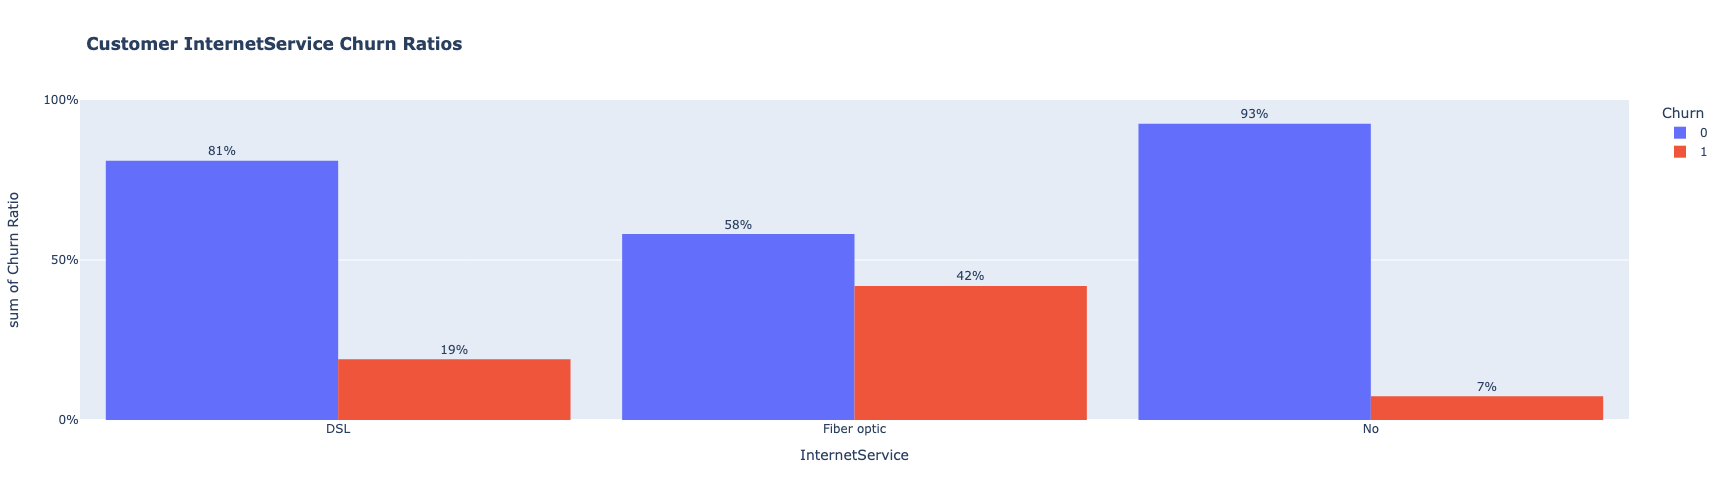

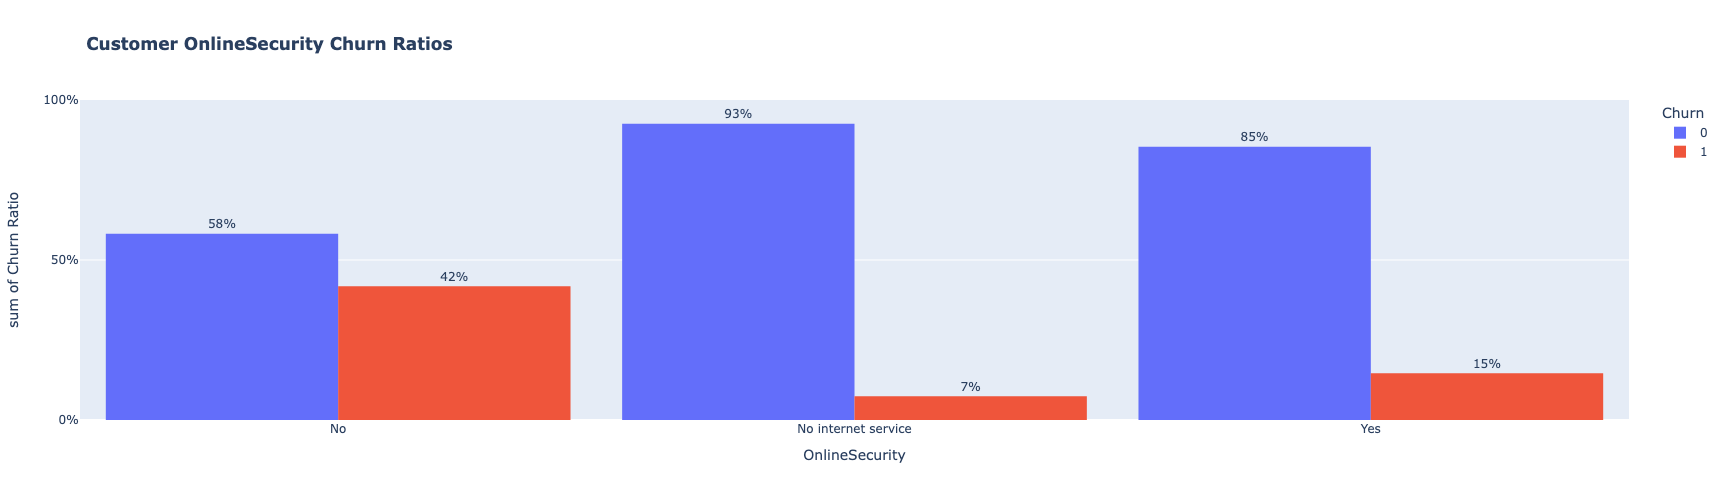

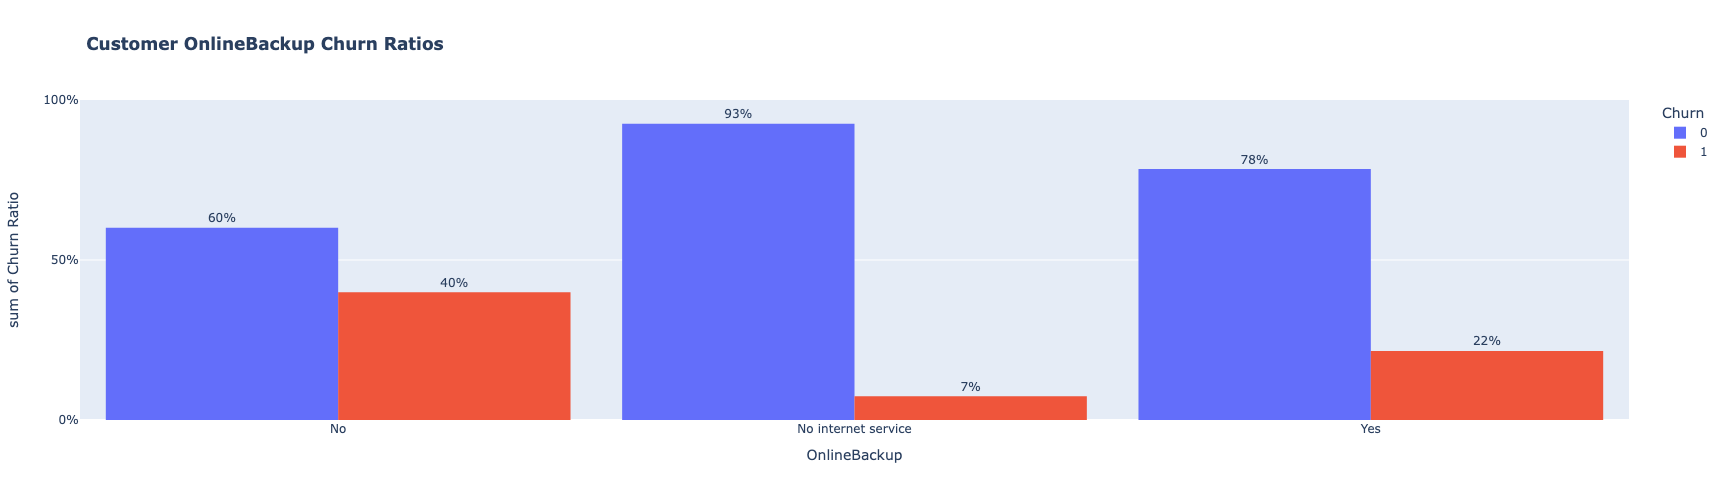

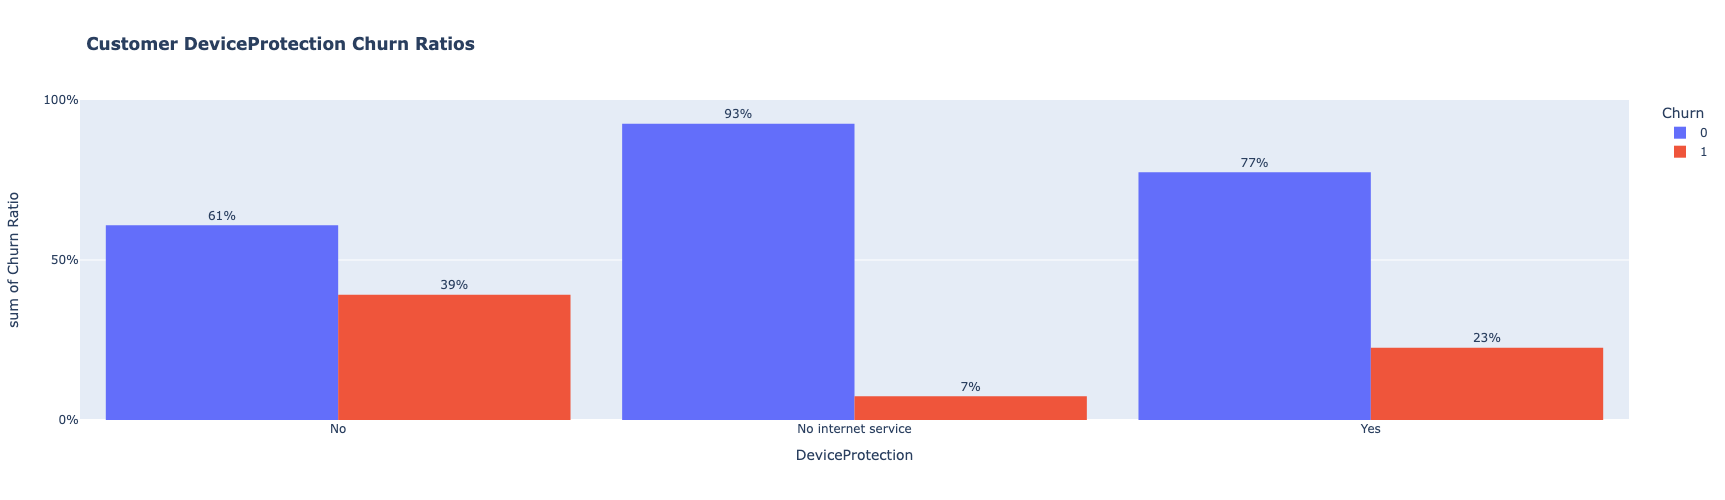

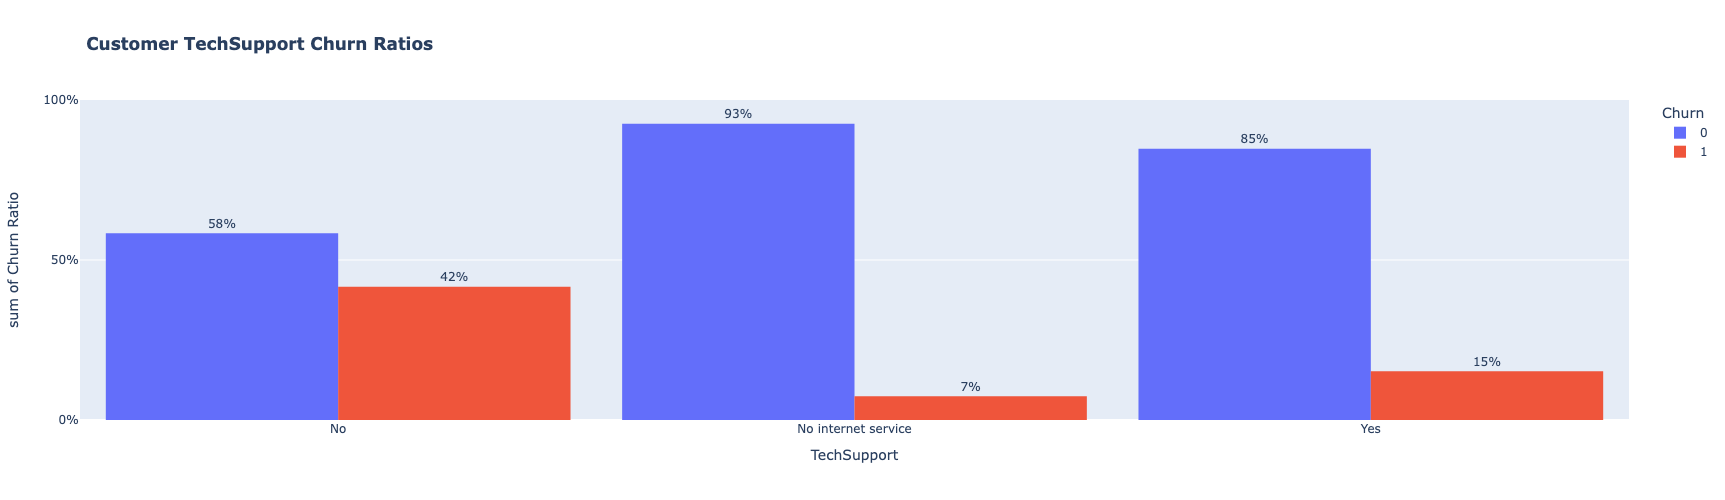

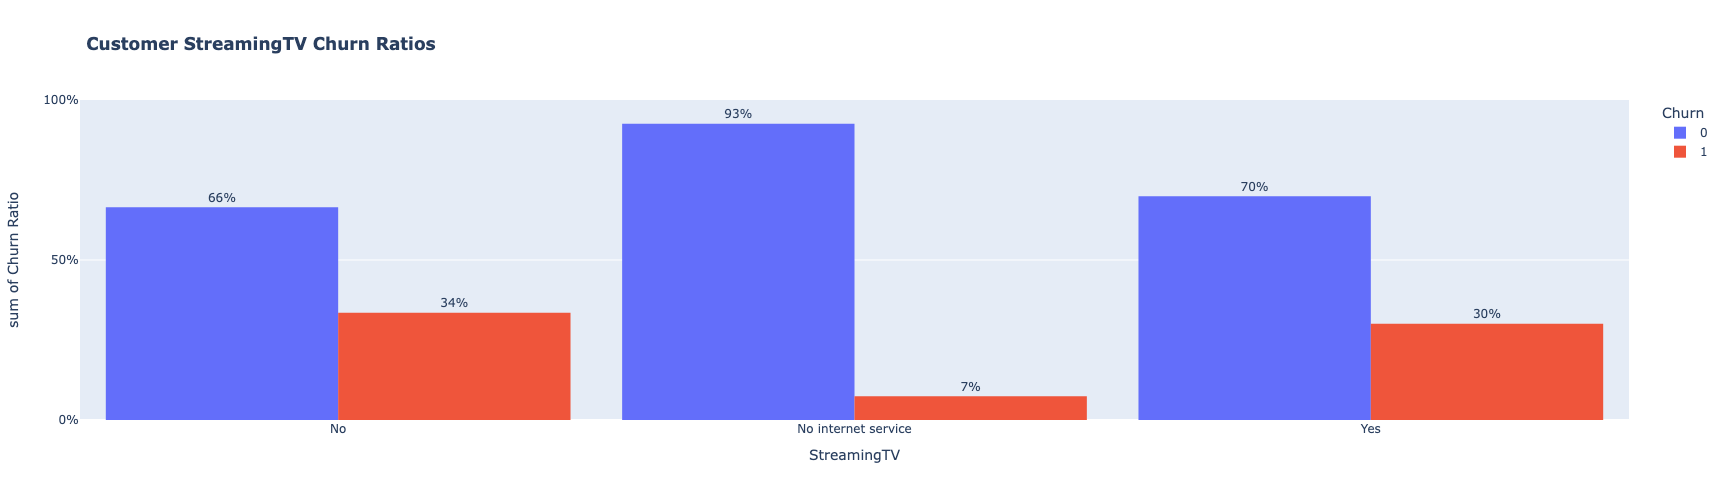

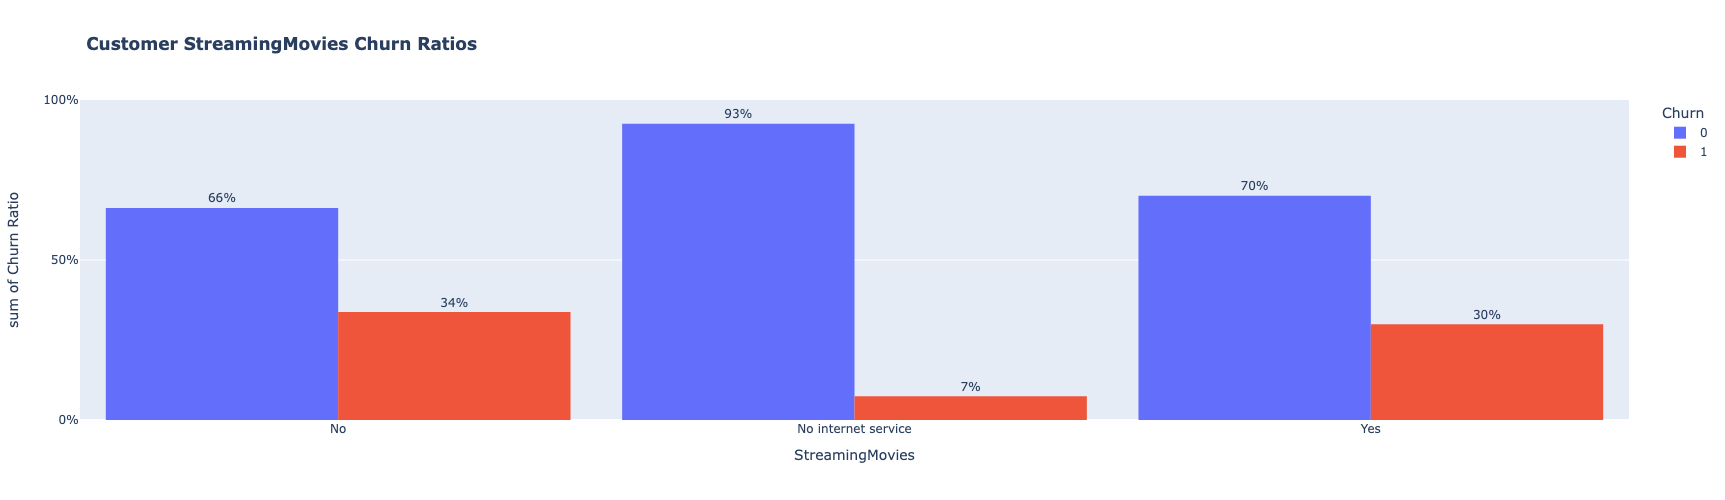

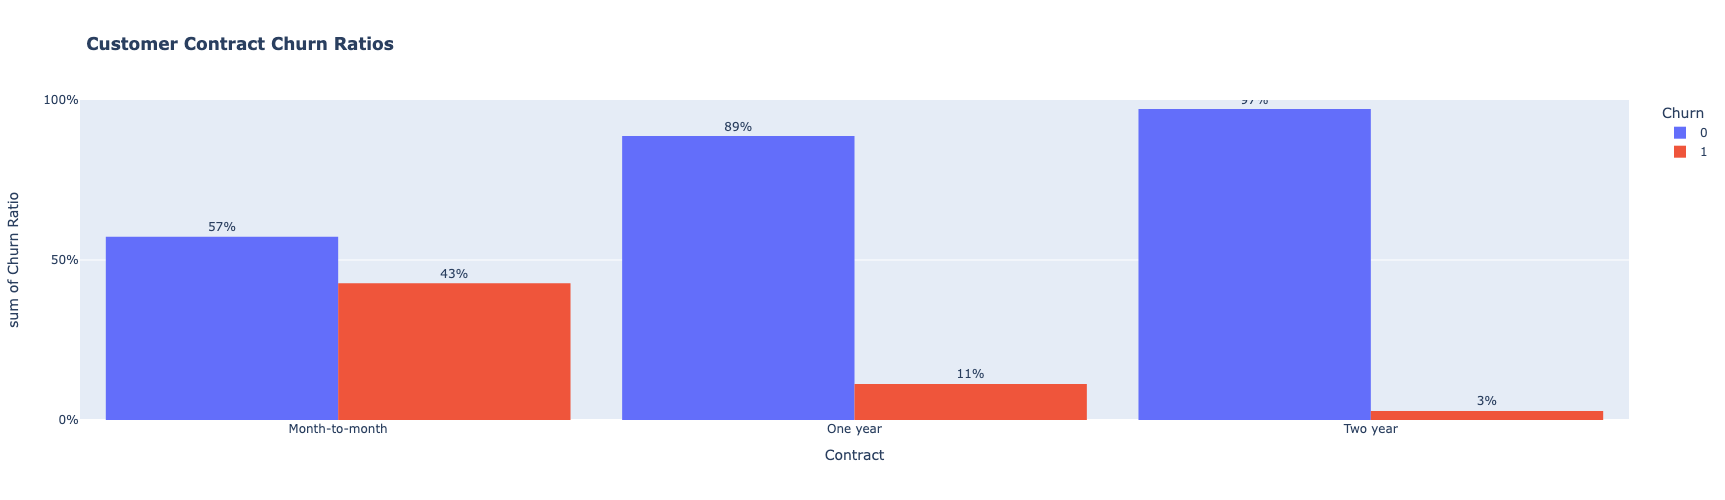

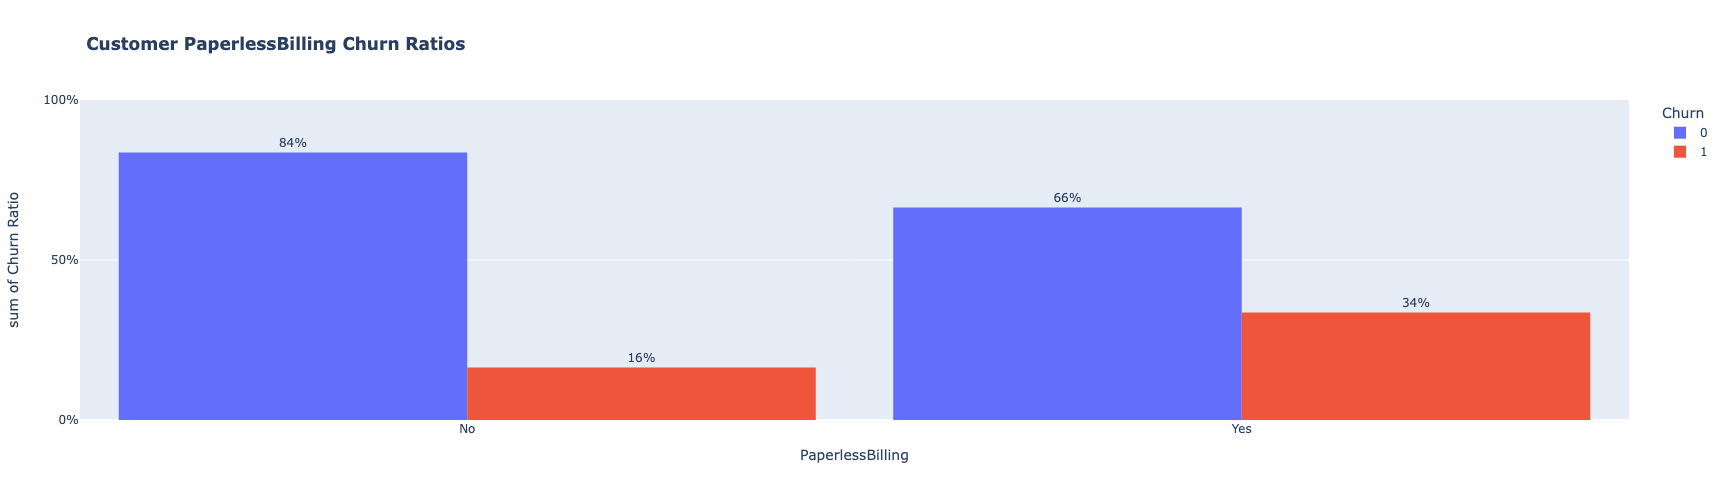

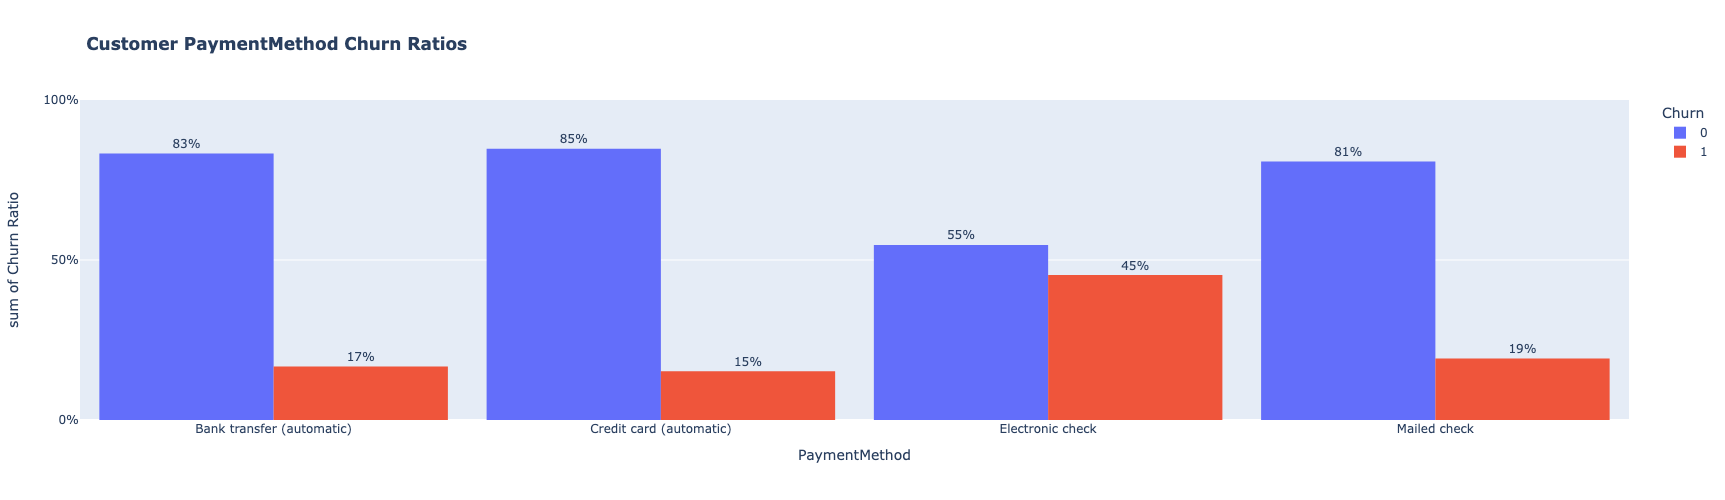

In [10]:
# Iterate over each categorical column in the DataFrame
for column in df.select_dtypes('object').columns:
    # Group by the current column and Churn, then calculate counts
    churn_data = df.groupby([column, 'Churn']).size().reset_index(name='Count')
    
    # Calculate total counts for the current column
    total_by_column = df[column].value_counts().reset_index()
    total_by_column.columns = [column, 'Total']
    
    # Merge to calculate churn ratios
    churn_data = churn_data.merge(total_by_column, on=column)
    churn_data['Churn Ratio'] = churn_data['Count'] / churn_data['Total']
    
    # Create the histogram plot
    fig = px.histogram(churn_data, 
                       x=column, 
                       y='Churn Ratio', 
                       color='Churn', 
                       barmode='group', 
                       title=f"<b>Customer {column} Churn Ratios<b>")
    
    # Add data labels
    fig.update_traces(texttemplate='%{y:.0%}', textposition='outside')
    
    # Update layout
    fig.update_layout(width=700, height=500, bargap=0.1, yaxis_tickformat='.0%')
    fig.update_yaxes(range=[0, 1], dtick=0.5)  # Set y-axis range and ticks
    
    # Show the figure
    fig.show()

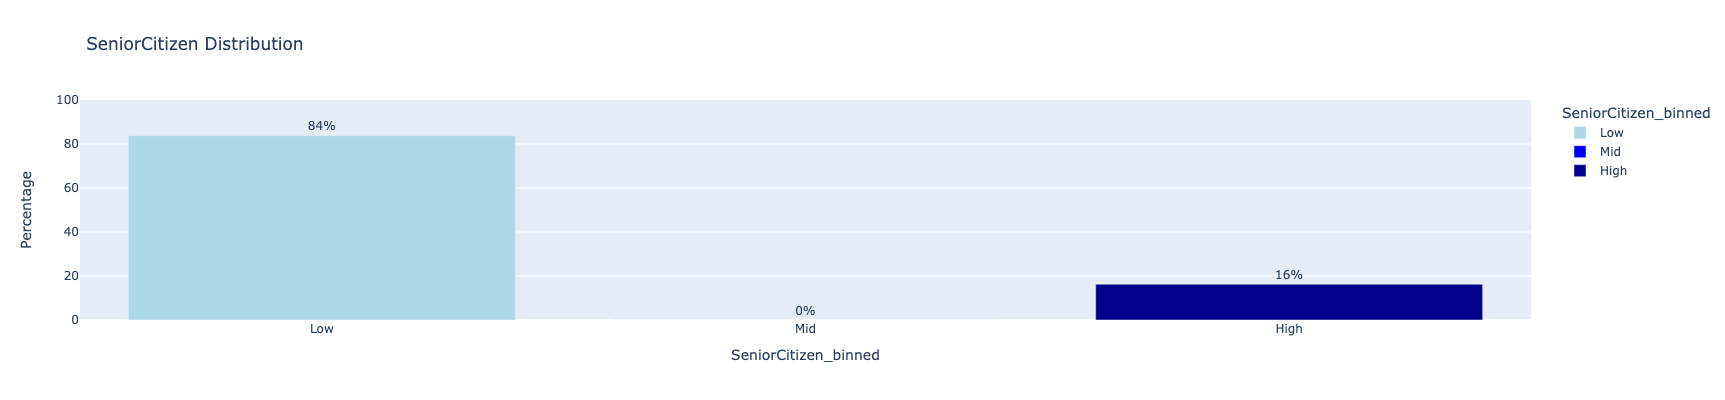

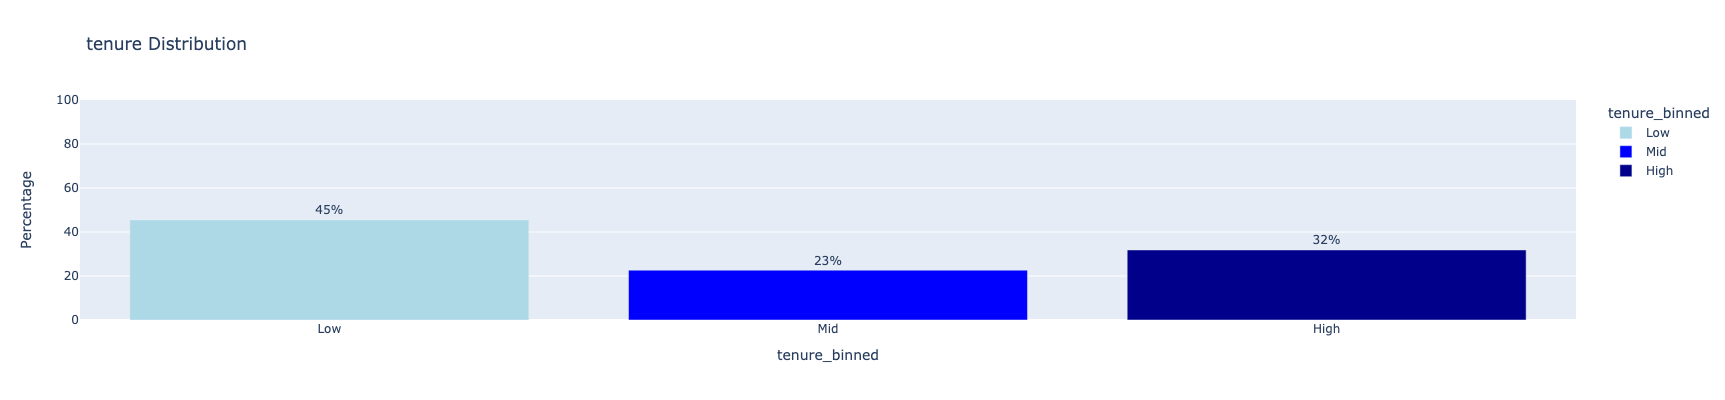

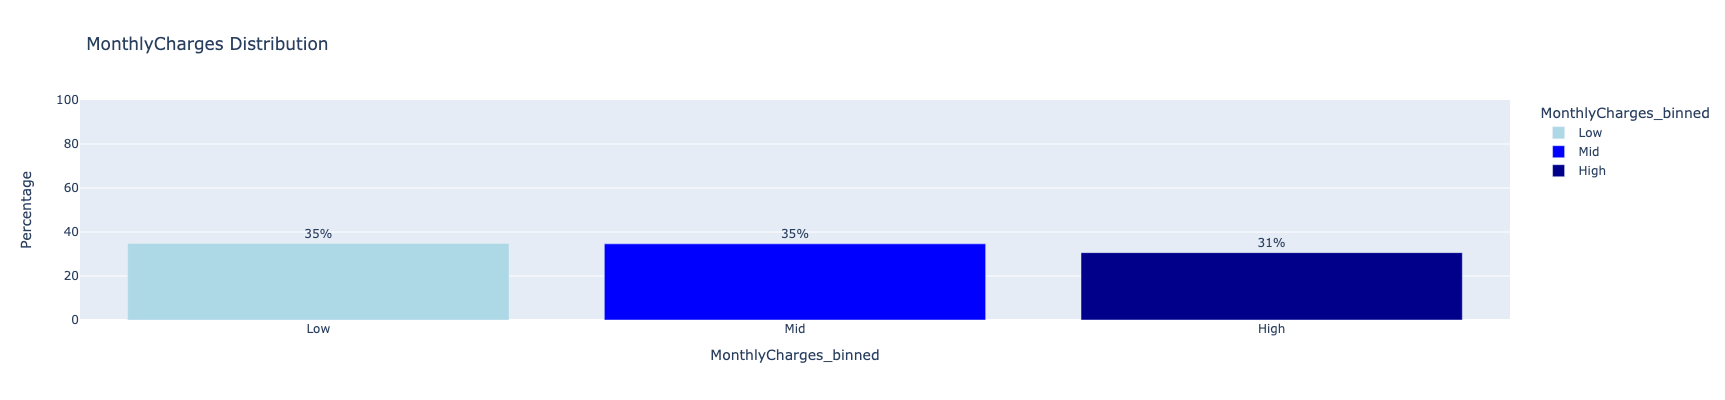

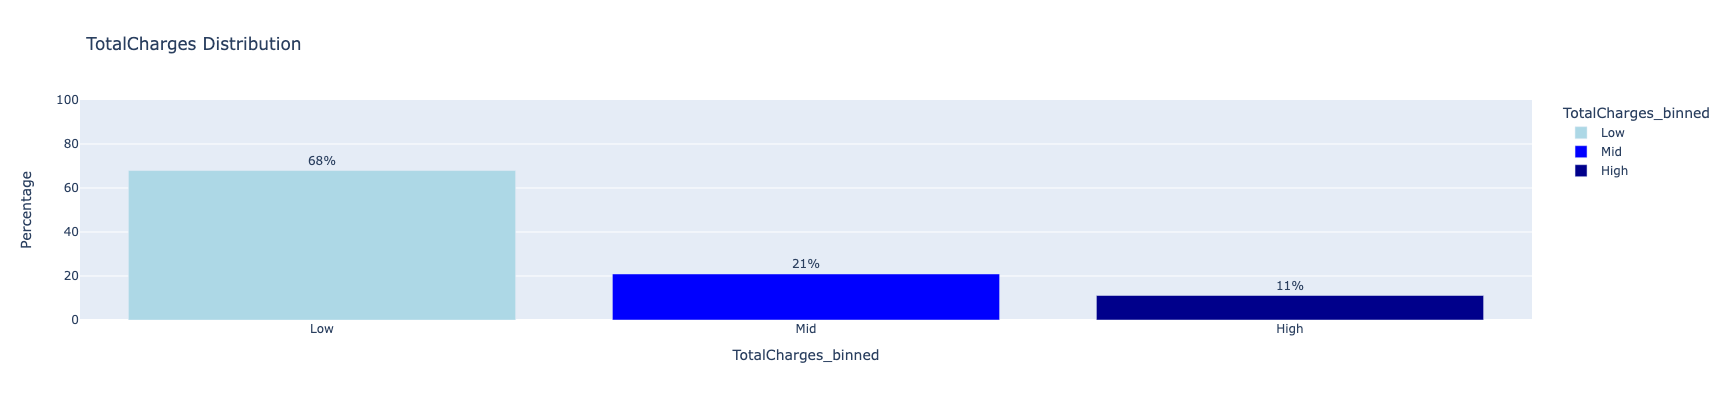

In [11]:
# coopy df to not add new columns
df_vis = df.copy()

# Define bins for categorizing numeric columns
bin_labels = ['Low', 'Mid', 'High']

# Iterate over each numeric column in the DataFrame, except 'Churn'
for column in df_vis.select_dtypes(include=['number']).columns:
    if column == 'Churn':
        continue
    
    # Bin the numeric column into three categories
    df_vis[f'{column}_binned'] = pd.cut(df_vis[column], bins=3, labels=bin_labels)
    
    # Calculate the distribution of each bin
    binned_counts = df_vis[f'{column}_binned'].value_counts(normalize=True).reset_index()
    binned_counts.columns = [f'{column}_binned', 'Percentage']
    binned_counts['Percentage'] *= 100  # Convert to percentage
    
    # Sort the bins to ensure the order is Low, Mid, High
    binned_counts = binned_counts.set_index(f'{column}_binned').reindex(bin_labels).reset_index()
    
    # Create a bar chart for the binned column
    fig = px.bar(binned_counts, 
                 x=f'{column}_binned', 
                 y='Percentage', 
                 title=f'{column} Distribution',
                 color=f'{column}_binned',
                 color_discrete_map={'Low': 'lightblue', 'Mid': 'blue', 'High': 'darkblue'})  # Color map
    
    # Add data labels
    fig.update_traces(texttemplate='%{y:.0f}%', textposition='outside')
    
    # Update layout
    fig.update_layout(width=600, height=400)
    fig.update_yaxes(range=[0, 100], dtick=20, tickformat='.0f%')  # Set y-axis to percentage
    
    # Show the figure
    fig.show()

# Getting Inferences -training and picking best machine learning algorithm to predict who'll churn

In [12]:
# Assuming df is your DataFrame
X = df.drop(columns=['Churn'])
y = df['Churn'].values

In [13]:
# Split into train, test, and holdout sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=40, stratify=y)
X_test, X_holdout, y_test, y_holdout = train_test_split(X_temp, y_temp, test_size=0.5, random_state=40, stratify=y_temp)

In [14]:
# Identify numerical and categorical columns
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()


In [15]:
# Standardize numerical columns
scaler = StandardScaler()

# Label encode categorical columns
label_encoders = {col: LabelEncoder() for col in cat_cols}

for col in cat_cols:
    X_train[col] = label_encoders[col].fit_transform(X_train[col])
    X_test[col] = label_encoders[col].transform(X_test[col])
    X_holdout[col] = label_encoders[col].transform(X_holdout[col])

In [16]:
# One-hot encode specified categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ],
    remainder='passthrough'
)

In [17]:
# Create a pipeline for each model
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1032
           1       0.66      0.56      0.61       374

    accuracy                           0.81      1406
   macro avg       0.75      0.73      0.74      1406
weighted avg       0.80      0.81      0.80      1406

ROC AUC Score: 0.85


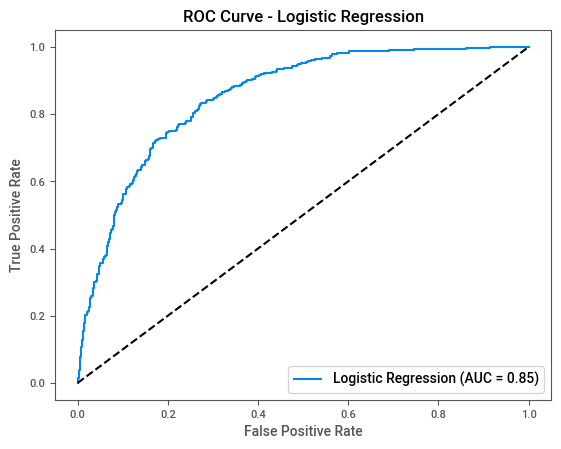

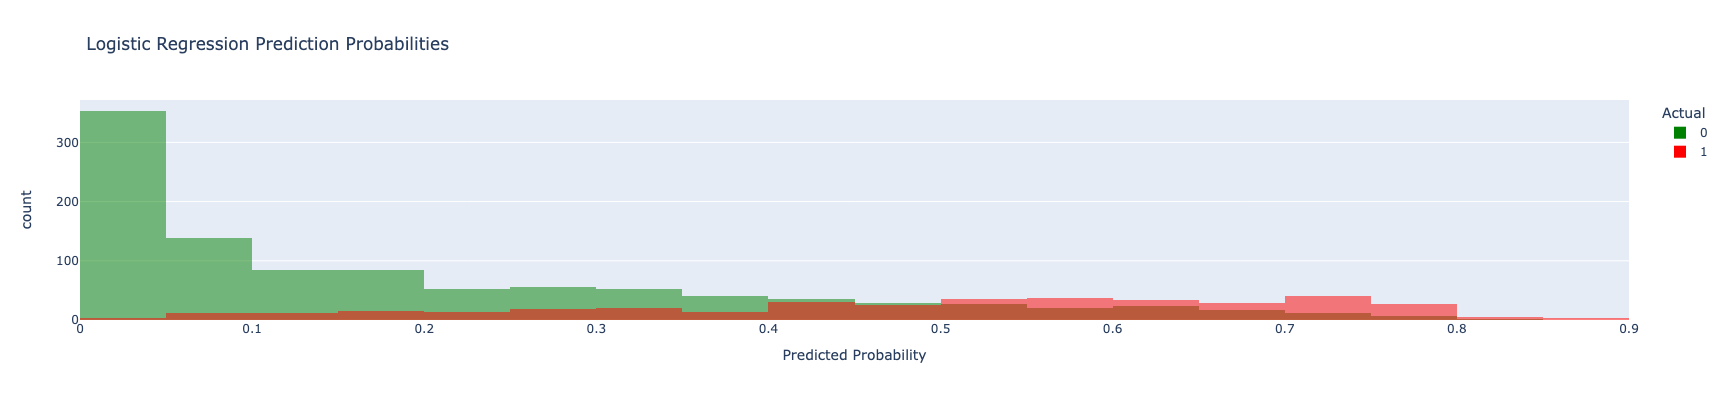

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1032
           1       0.63      0.52      0.57       374

    accuracy                           0.79      1406
   macro avg       0.73      0.70      0.71      1406
weighted avg       0.78      0.79      0.78      1406

ROC AUC Score: 0.83


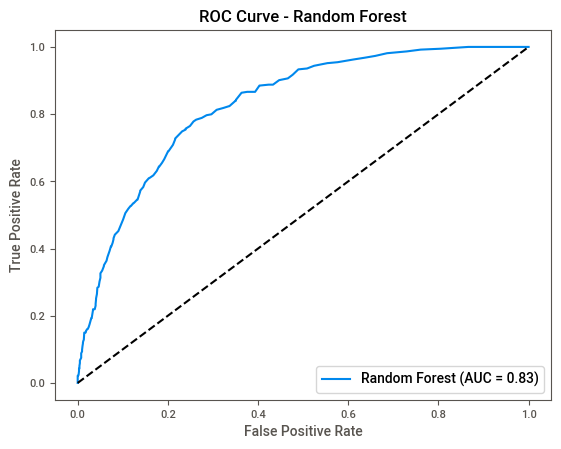

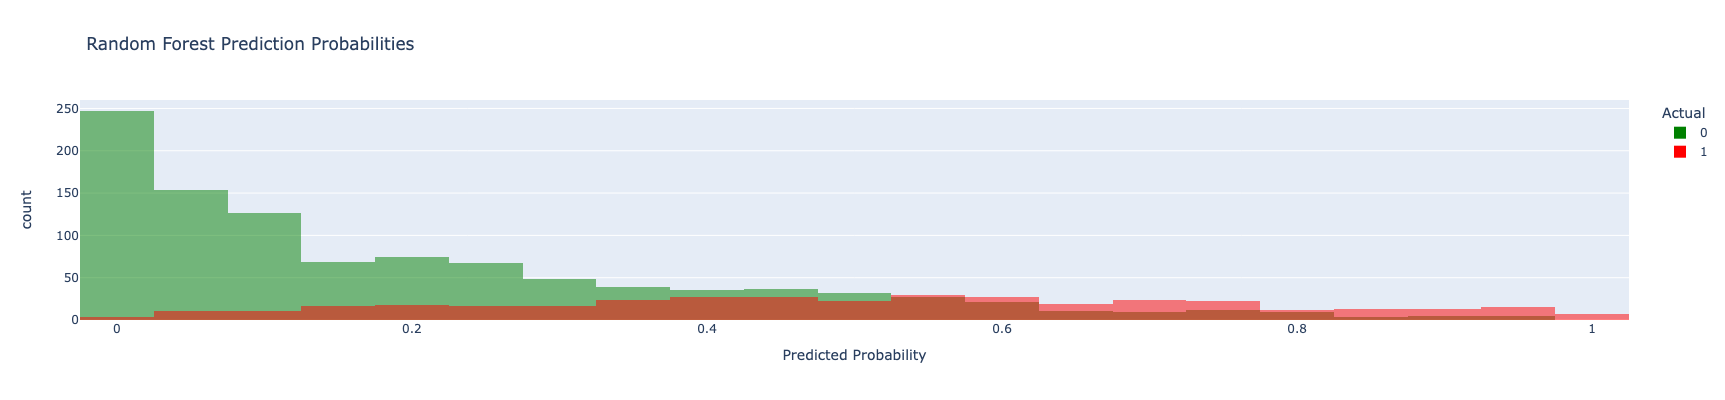

--- Support Vector Machine ---
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1032
           1       0.68      0.49      0.57       374

    accuracy                           0.80      1406
   macro avg       0.76      0.71      0.72      1406
weighted avg       0.79      0.80      0.79      1406

ROC AUC Score: 0.80


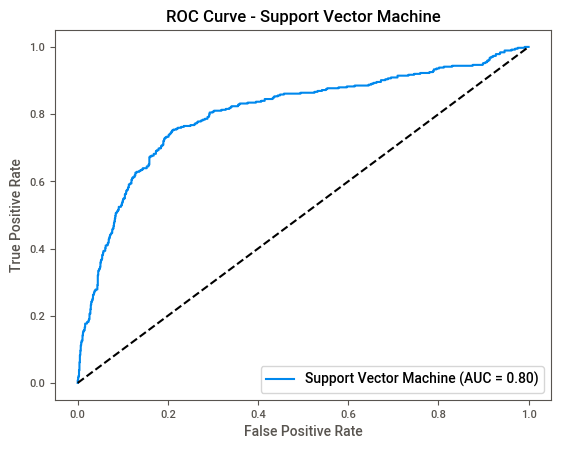

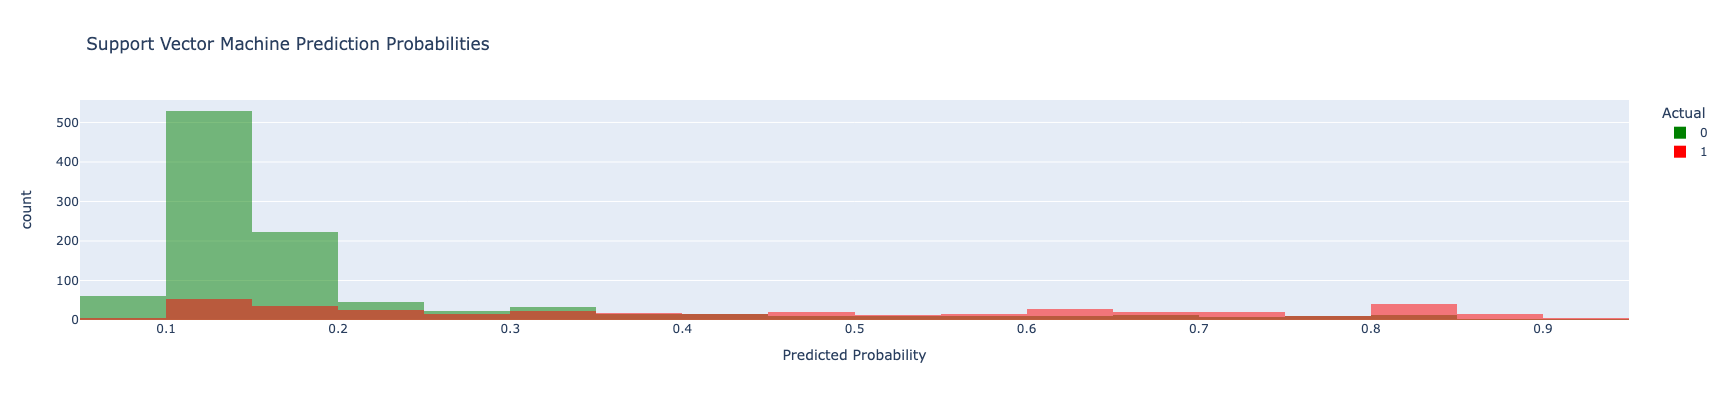

--- Gradient Boosting ---
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1032
           1       0.66      0.53      0.59       374

    accuracy                           0.80      1406
   macro avg       0.75      0.72      0.73      1406
weighted avg       0.79      0.80      0.80      1406

ROC AUC Score: 0.85


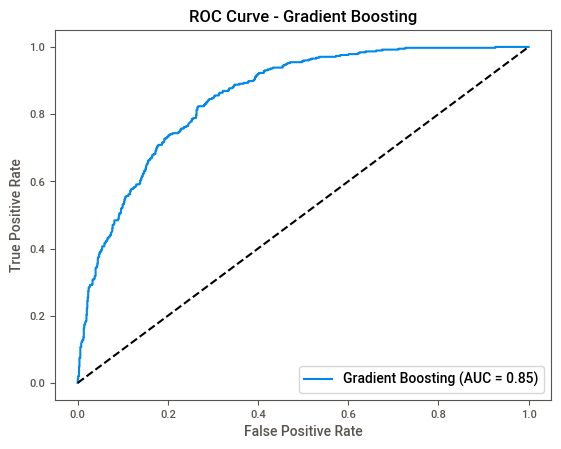

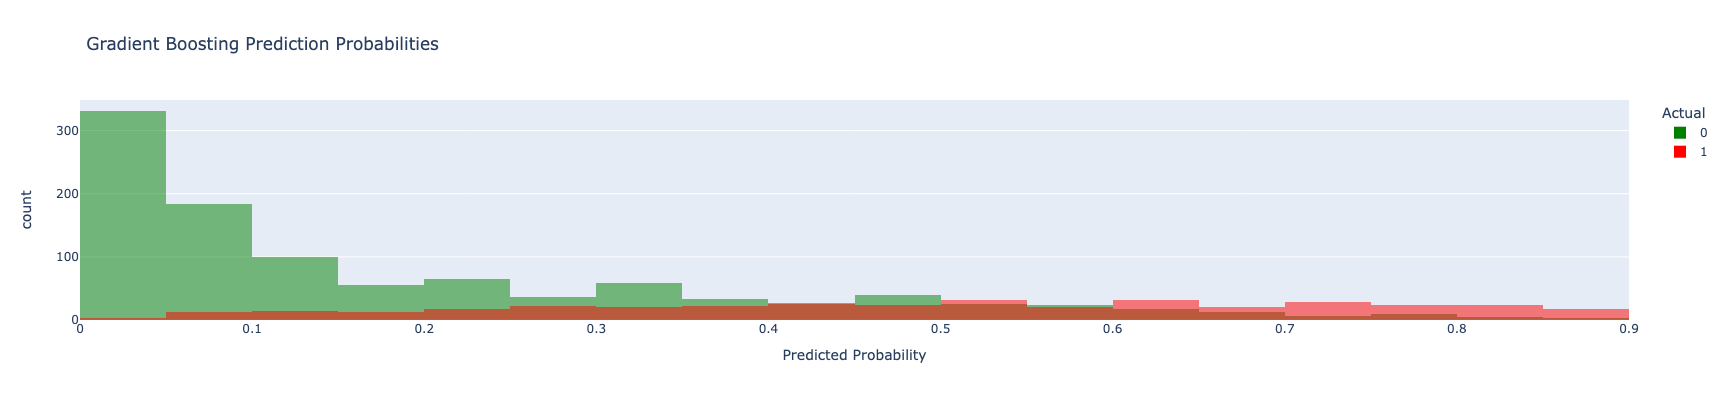

--- K-Nearest Neighbors ---
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1032
           1       0.53      0.51      0.52       374

    accuracy                           0.75      1406
   macro avg       0.68      0.67      0.68      1406
weighted avg       0.75      0.75      0.75      1406

ROC AUC Score: 0.77


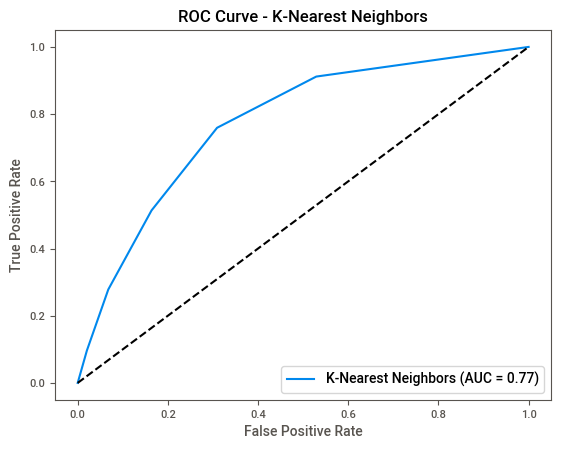

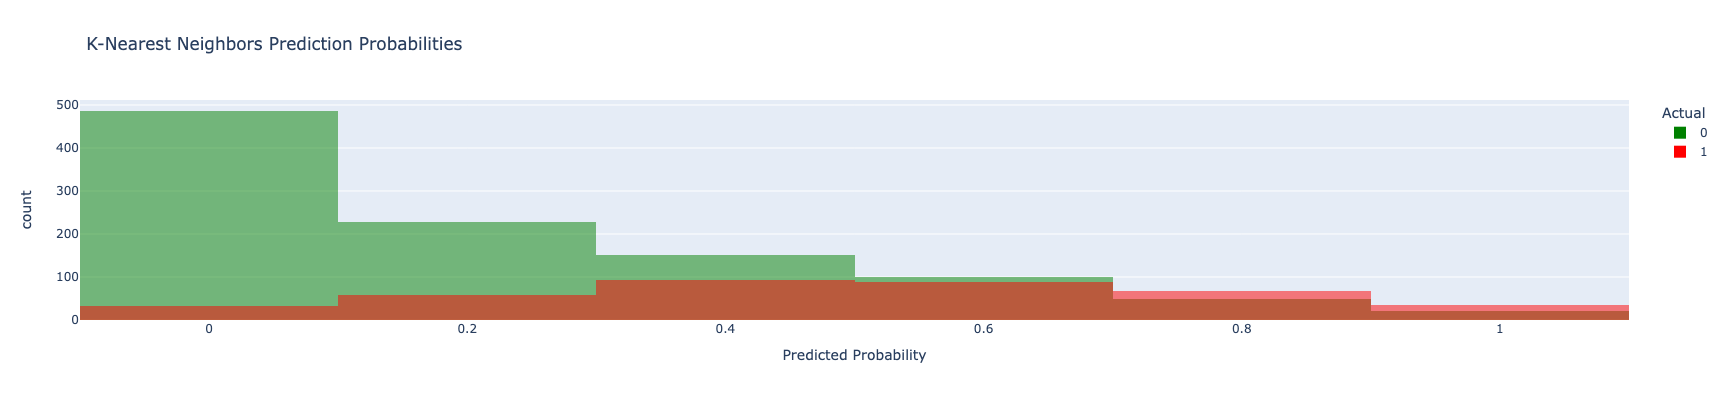

--- XGBoost ---
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1032
           1       0.59      0.53      0.56       374

    accuracy                           0.78      1406
   macro avg       0.71      0.70      0.71      1406
weighted avg       0.77      0.78      0.77      1406

ROC AUC Score: 0.83


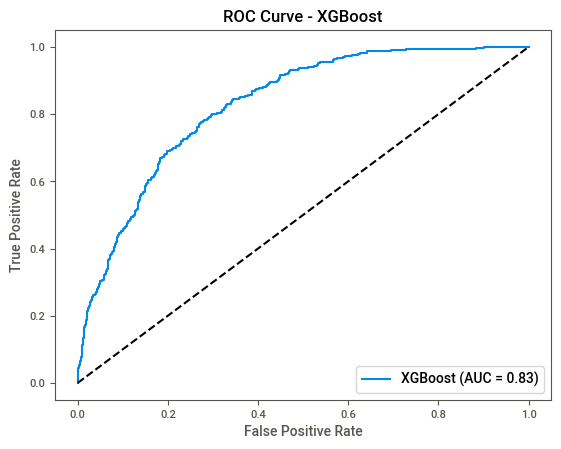

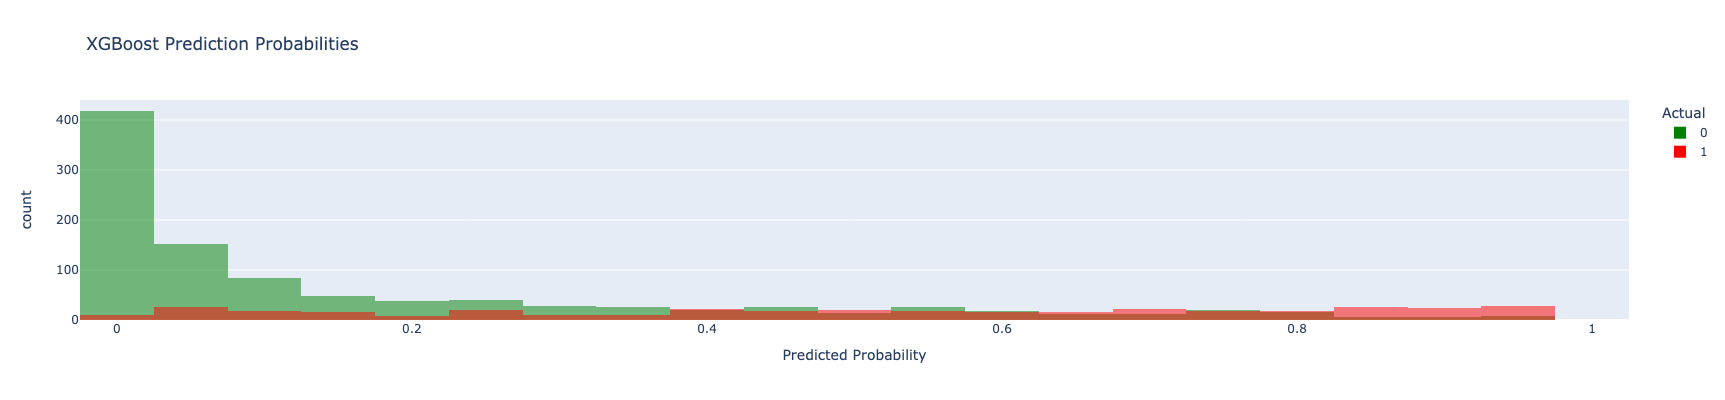

In [18]:
# Dictionary to store model performance
model_performance = {}

# Train and evaluate each model
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculate ROC AUC
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC Score: {roc_auc:.2f}")

    # Store performance metrics
    model_performance[name] = {
        'ROC AUC': roc_auc,
        'Accuracy': (y_pred == y_test).mean(),
        'Precision': classification_report(y_test, y_pred, output_dict=True)['1']['precision'],
        'Recall': classification_report(y_test, y_pred, output_dict=True)['1']['recall']
    }

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')
    plt.show()

    # Visualize prediction probabilities
    pred_df = pd.DataFrame({'Actual': y_test, 'Predicted Probability': y_proba})
    fig = px.histogram(pred_df, x='Predicted Probability', color='Actual', 
                       title=f'{name} Prediction Probabilities',
                       barmode='overlay', 
                       color_discrete_map={0: 'green', 1: 'red'})
    fig.update_layout(width=600, height=400)
    fig.show()

In [19]:
# Convert model performance dictionary to DataFrame
performance_df = pd.DataFrame(model_performance).T
performance_df.sort_values(by='ROC AUC', ascending=False)

ROC AUC  Accuracy  Precision    Recall
Logistic Regression     0.854470  0.806543   0.660377  0.561497
Gradient Boosting       0.853760  0.802276   0.658940  0.532086
Random Forest           0.829146  0.789474   0.625806  0.518717
XGBoost                 0.827620  0.777383   0.590504  0.532086
Support Vector Machine  0.802962  0.804410   0.682657  0.494652
K-Nearest Neighbors     0.774268  0.750356   0.531856  0.513369